# Appendix A - Code

## Get data from Open Prescribing API

In [1]:
import json
import urllib2
import numpy as np
import matplotlib.pyplot as plt
import datetime

def get_percentiles_for(measure, location):
    percentiles = []
    dates = []
    calc_value = []
    #for CCGs
    if len(location) == 3:
        # Create a request to the API
        url = ('https://openprescribing.net/'
           'api/1.0/measure_by_ccg/?format=json&measure=' + measure)
        request = urllib2.Request(url)
        
        # Pretend to be a real web browser
        request.add_header(
            'User-Agent',
            'Mozilla/5.0 (X11; U; Linux i686) '
            'Gecko/20071127 Firefox/2.0.0.11')
        opener = urllib2.build_opener()
        response = opener.open(request).read()

        # Convert the JSON string into a python dictionary
        data = json.loads(response)

        # Extract the data about the CCG we're interested in
        for datum in data['measures'][0]['data']:
            if datum['pct_id'] == location:
                percentiles.append(datum['percentile'])
                dates.append(datum['date'])
                calc_value.append(datum['calc_value'])
    #for practices:
    else:
        # Create a request to the API
        url = ('https://openprescribing.net/'
           'api/1.0/measure_by_practice/?format=json&org=' + location)
        request = urllib2.Request(url)
        
        # Pretend to be a real web browser
        request.add_header(
            'User-Agent',
            'Mozilla/5.0 (X11; U; Linux i686) '
            'Gecko/20071127 Firefox/2.0.0.11')
        opener = urllib2.build_opener()
        response = opener.open(request).read()

        # Convert the JSON string into a python dictionary
        data = json.loads(response)
        
        # Extract the data about the measure we're interested in
        for n in range(len(data['measures'])):
            if data['measures'][n]['id'] == measure:
                for datum in data['measures'][n]['data']:
                    #print datum
                    percentiles.append(datum['percentile'])
                    dates.append(datum['date'])
                    calc_value.append(datum['calc_value'])
    #convert missing percentile values from None to numpy nan
    percentiles2 = np.array(map(lambda x: np.nan
                                if x==None else x, percentiles))
    return {'percentiles':percentiles2,
            'dates':dates,
            'calc_value':calc_value}

def get_measures():
    measures = []
    url = ('https://openprescribing.net/'
       'api/1.0/measure_by_practice/?format=json&org=G82105')
    request = urllib2.Request(url)
    request.add_header(
        'User-Agent',
        'Mozilla/5.0 (X11; U; Linux i686) '
        'Gecko/20071127 Firefox/2.0.0.11')
    opener = urllib2.build_opener()
    response = opener.open(request).read()
    data = json.loads(response)

    # Extract the data about the measure we're interested in
    #for n in range(len(data['measures'])):
    for datum in data['measures']:
        #print datum
        measures.append(datum['id'])
    return measures



In [2]:
def get_ccgs_practices():
    with open('Patient_List_Size_CCG_2016_09.csv') as csvfile:
        ccgs = []
        ccgs_import = csv.reader(csvfile, delimiter=',')
        for row in ccgs_import:
            ccgs.append(row[0])
    with open('gp-reg-patients-prac-quin-age_2019_09.csv') as csvfile:
        practices = []
        practices_import = csv.reader(csvfile, delimiter=',')
        for row in practices_import:
            practices.append(row[0])
    return {'ccgs':ccgs, 'practices':practices}

## Import deciles from csv

In [8]:
import csv
def get_deciles(measure, location):
    with open('allmeasuresdeciles_12_16.csv') as csvfile:
        deciles_import = csv.reader(csvfile, delimiter=',')
        date = []
        d_10 = []
        d_20 = []
        d_30 = []
        d_40 = []
        d_50 = []
        d_60 = []
        d_70 = []
        d_80 = []
        d_90 = []
        for row in deciles_import:
            if row[1] == measure:
                date.append(row[0])
                if len(location) == 3:
                    d_10.append(float(row[2]))
                    d_20.append(float(row[3]))
                    d_30.append(float(row[4]))
                    d_40.append(float(row[5]))
                    d_50.append(float(row[6]))
                    d_60.append(float(row[7]))
                    d_70.append(float(row[8]))
                    d_80.append(float(row[9]))
                    d_90.append(float(row[10]))
                else:
                    d_10.append(float(row[11]))
                    d_20.append(float(row[12]))
                    d_30.append(float(row[13]))
                    d_40.append(float(row[14]))
                    d_50.append(float(row[15]))
                    d_60.append(float(row[16]))
                    d_70.append(float(row[17]))
                    d_80.append(float(row[18]))
                    d_90.append(float(row[19]))
        dates = [datetime.datetime.strptime(date, 
                        '%d/%m/%Y').date() for date in date]
    return {'dates':dates,
            'd_10':d_10,'d_20':d_20,'d_30':d_30,
            'd_40':d_40,'d_50':d_50,'d_60':d_60,
            'd_70':d_70,'d_80':d_80,'d_90':d_90}

## CUSUM algorithm

In [9]:
def cusum(data,months_smoothing,sensitivity):
    """performs the CUSUM algorithm on input data string"""
    smax = [0]
    smin = [0]
    # set reference_percentile and threshold at start
    # & if threshold reached
    non_missing_percentiles = data[~np.isnan(data)]
    reference_percentile = [np.mean(non_missing_percentiles
                                    [0:months_smoothing])] 
    threshold = [np.std(non_missing_percentiles[0:months_smoothing]) 
                 * sensitivity] # +remove nan values
    alert = []
    alert_percentile_pos = [None]
    alert_percentile_neg = [None]
    for i in range(1,len(data)):
        
        if smax[i-1] > threshold[i-1] or smin[i-1] < -threshold[i-1]:
            #generate temp smax/smin
            reference_percentile.append \
                    (np.mean(data[i-months_smoothing:i]
                    [~np.isnan(data[i-months_smoothing:i])])) 
            smax_temp = (max(0, data[i] - (reference_percentile[i] + 
                                           (0.5 * threshold[i-1] / 
                                            sensitivity)) + smax[i-1]))
            smin_temp = (min(0, data[i] - (reference_percentile[i] - 
                                           (0.5 * threshold[i-1] / 
                                            sensitivity)) + smin[i-1]))

            #test whether change still occuring *IN THE SAME DIRECTION*
            ## positive change
            if smax[i-1] < smax_temp and smax[i-1] > threshold[i-1]:
                threshold.append(threshold[i-1])
                smax.append(smax_temp)
                smin.append(smin_temp)
                alert.append(i-1)
                alert_percentile_pos.append(data[i])
                alert_percentile_neg.append(None)
            
            ## negative change
            elif smin[i-1] > smin_temp and smin[i-1] < -threshold[i-1]:
                threshold.append(threshold[i-1])
                smax.append(smax_temp)
                smin.append(smin_temp)
                alert.append(i-1)
                alert_percentile_pos.append(None)
                alert_percentile_neg.append(data[i])
                
            ## if not, reset
            else:
                alert.append(i-1)
                threshold.append(np.std(data[i-months_smoothing:i]
                                [~np.isnan(data[i-months_smoothing:i])])
                                 * sensitivity) # +remove nan values
                #reset smax/smin to 0
                #modified to include the value for the current month
                smax.append(max(0, data[i] - (reference_percentile[i] +
                                              (0.5 * threshold[i] /
                                               sensitivity))))
                smin.append(min(0, data[i] - (reference_percentile[i] -
                                              (0.5 * threshold[i] /
                                               sensitivity))))
                alert_percentile_pos.append(None)
                alert_percentile_neg.append(None)
                
        #else append previous values
        else:
            reference_percentile.append(reference_percentile[i-1])
            threshold.append(threshold[i-1])
            
            #calculate smax/smin
            smax.append(max(0, data[i] - (reference_percentile[i] +
                                          (0.5 * threshold[i] /
                                           sensitivity)) + smax[i-1]))
            smin.append(min(0, data[i] - (reference_percentile[i] -
                                          (0.5 * threshold[i] /
                                           sensitivity)) + smin[i-1]))
            
            if smax[i] > threshold[i]:
                alert_percentile_pos.append(data[i])
                alert_percentile_neg.append(None)
            elif smin[i] < -threshold[i]:
                alert_percentile_neg.append(data[i])
                alert_percentile_pos.append(None)
            else:
                alert_percentile_pos.append(None)
                alert_percentile_neg.append(None)
    return {'smax':smax, 'smin':smin,
            'reference_percentile':reference_percentile, 
            'threshold':threshold,
            'alert':alert,
            'alert_percentile_pos':alert_percentile_pos,
            'alert_percentile_neg':alert_percentile_neg}

## Draw plots

In [10]:
def draw_plots(cusum_out, percentiles, dates, deciles):
    """draws 3 plots containing measure, alerts and CUSUM"""
    #plot deciles and percentile values
    negthreshold = [ -x for x in cusum_out['threshold']]
    plt.figure(figsize=(5, 10))
    plt.subplot(311)
    plt.plot(deciles['dates'],deciles['d_10'], 
             color = '#298CFF', linestyle = ':')
    plt.plot(deciles['dates'],deciles['d_20'], 
             color = '#298CFF', linestyle = ':')
    plt.plot(deciles['dates'],deciles['d_30'], 
             color = '#298CFF', linestyle = ':')
    plt.plot(deciles['dates'],deciles['d_40'], 
             color = '#298CFF', linestyle = ':')
    plt.plot(deciles['dates'],deciles['d_50'], 
            color = '#298CFF', label = 'Median')
    plt.plot(deciles['dates'],deciles['d_60'], 
             color = '#298CFF', linestyle = ':')
    plt.plot(deciles['dates'],deciles['d_70'], 
             color = '#298CFF', linestyle = ':')
    plt.plot(deciles['dates'],deciles['d_80'], 
             color = '#298CFF', linestyle = ':')
    plt.plot(deciles['dates'],deciles['d_90'], 
             color = '#298CFF', linestyle = ':', label = 'Deciles')
    plt.plot(dates,percentiles['calc_value'], 
             'r', label = 'Measure')
    plt.ylabel('measure')
    plt.legend(bbox_to_anchor=(1.02, 1), 
               loc=2, borderaxespad=0.,fontsize=10)

    
    #plot percentile and determined percentile
    plt.subplot(312)
    plt.plot(dates,percentiles['percentiles'], 
             'g', label = 'Percentile')
    plt.plot(dates,cusum_out['alert_percentile_pos'], 
             'ro', label = 'Increase alerts')
    plt.plot(dates,cusum_out['reference_percentile'], 
             'b', label = 'Reference percentile')
    plt.plot(dates,cusum_out['alert_percentile_neg'], 
             'go', label = 'Decrease alerts')
    plt.ylabel('percentile')
    plt.legend(bbox_to_anchor=(1.02, 1), 
               loc=2, borderaxespad=0.,fontsize=10)
    
    #plot CUSUM/threshold graph
    plt.subplot(313)
    plt.plot(dates,cusum_out['smax'], 
             'c', label = 'CUSUM +ve')
    plt.plot(dates,cusum_out['smin'], 
             'r', label = 'CUSUM -ve')
    plt.plot(dates,cusum_out['threshold'], 
             'k--', label = 'Thresholds')
    plt.plot(dates,negthreshold, 
             'k--')
    plt.ylabel('CUSUM')
    plt.legend(bbox_to_anchor=(1.02, 1), 
               loc=2, borderaxespad=0.,fontsize=10)
    
    plt.show()
    print ''
    print ''
    print ''

## Testing

In [18]:
#Analyse
def analyse(measure, location):
    if len(location) == 3:
        print "Measure: https://openprescribing.net/ccg/%s/#%s" % (location, measure)
    else:
        print "Measure: https://openprescribing.net/practice/%s/#%s" % (location, measure)
    #CHANGE THESE to alter the MEASURE and/or CCG/PRACTICE
    percentiles_dates = get_percentiles_for(measure, location)
    dates = [datetime.datetime.strptime(date, '%Y-%m-%d').date() 
             for date in percentiles_dates['dates']]
    deciles = get_deciles(measure, location)
        
    #CHANGE THESE NUMBERS to adjust SMOOTHING PERIOD and SENSITIVITY
    cusum_out = cusum(percentiles_dates['percentiles'],12,5)
    draw_plots(cusum_out, percentiles_dates, dates, deciles)

# Appendix B -Example graphs

Measure: https://openprescribing.net/ccg/05Y/#fungal


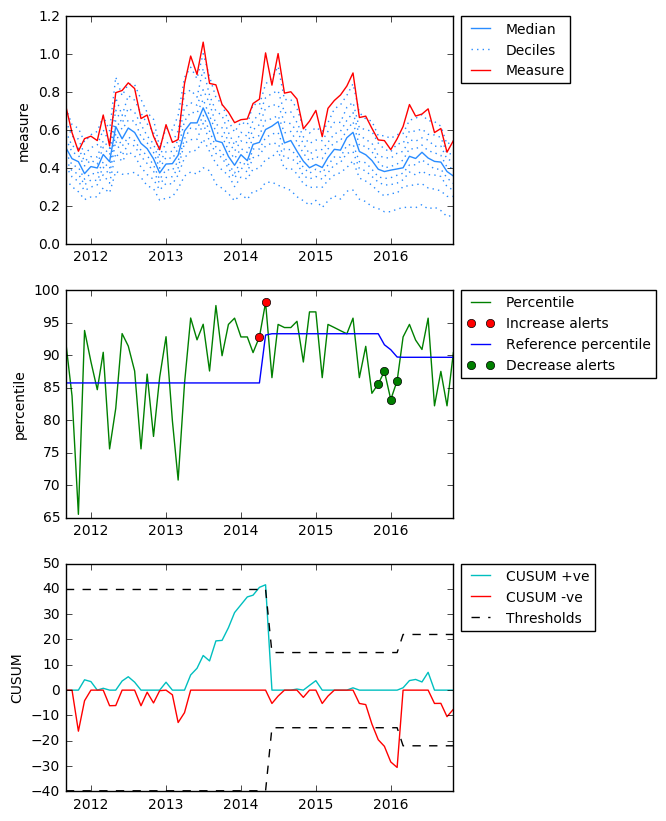




Measure: https://openprescribing.net/practice/G85138/#fungal


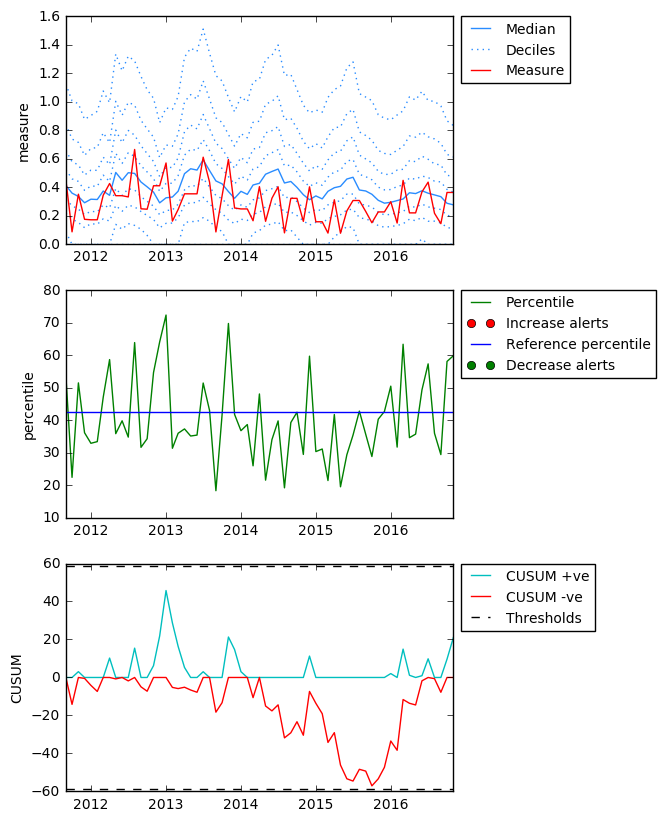




Measure: https://openprescribing.net/ccg/05Y/#ppi


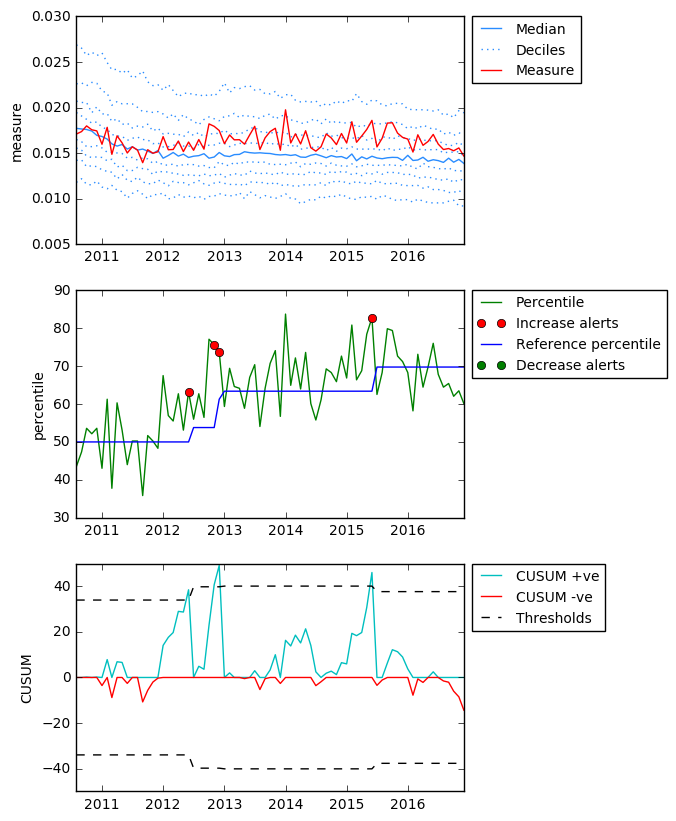




Measure: https://openprescribing.net/practice/G85138/#ppi


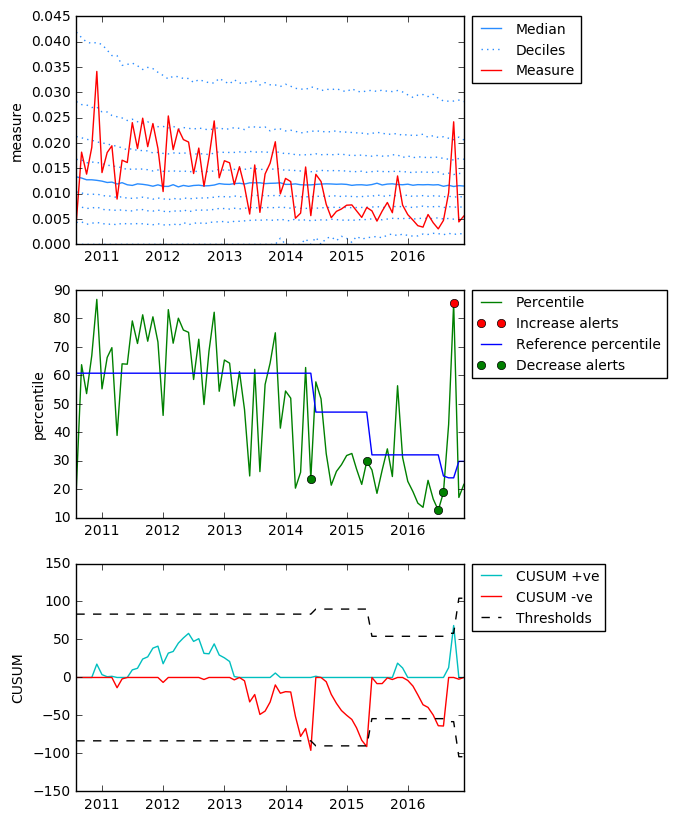




Measure: https://openprescribing.net/ccg/05Y/#tramadol


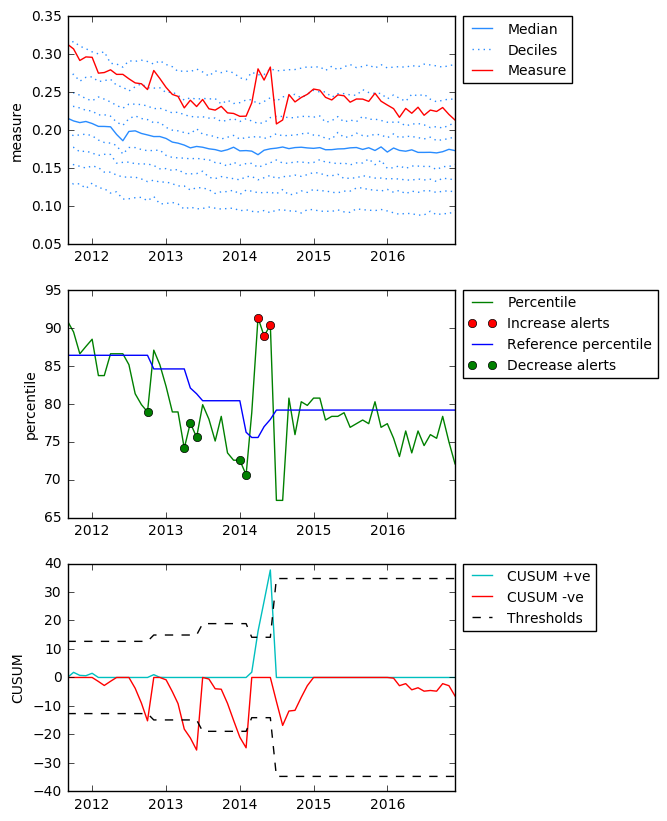




Measure: https://openprescribing.net/practice/G85138/#tramadol


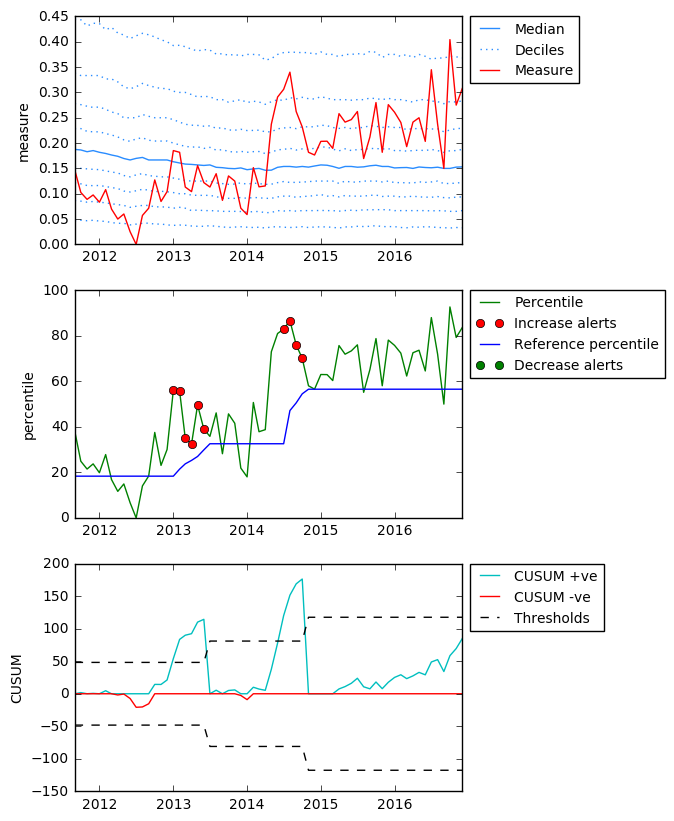




Measure: https://openprescribing.net/ccg/05Y/#sildenafil


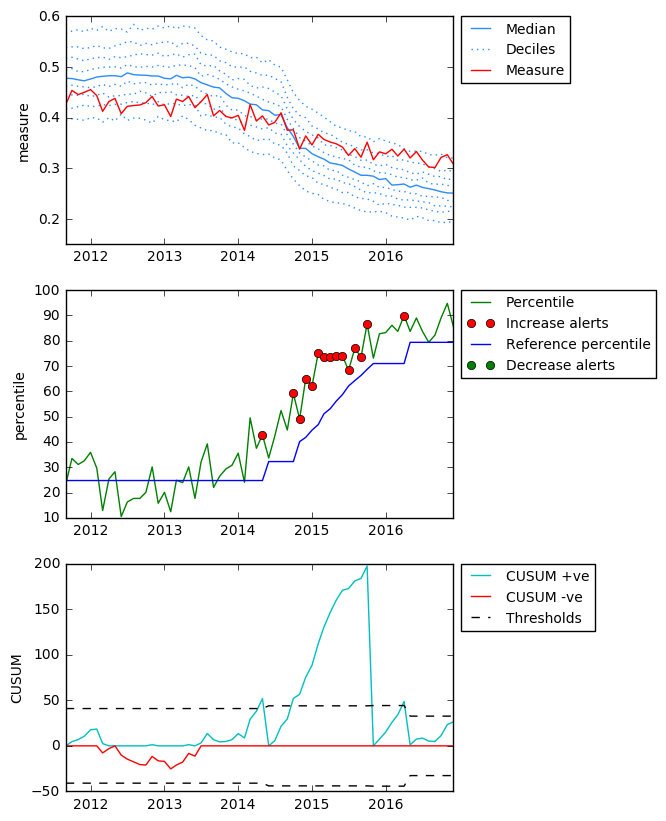




Measure: https://openprescribing.net/practice/G85138/#sildenafil


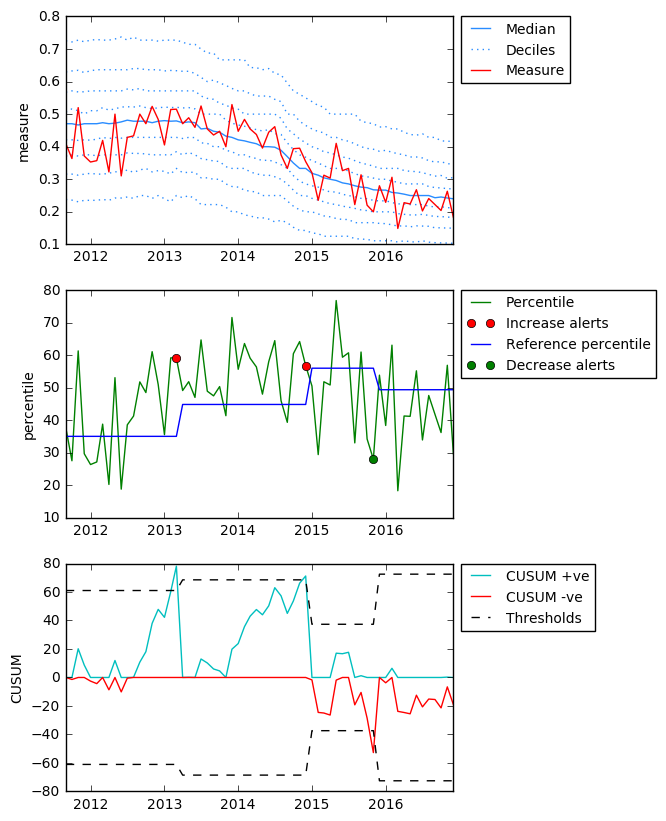




Measure: https://openprescribing.net/ccg/05Y/#arb


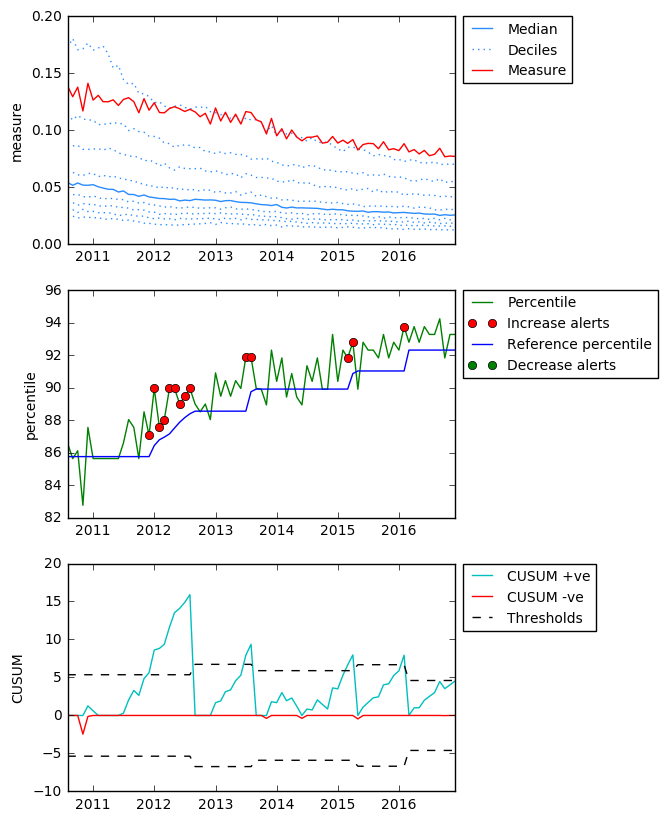




Measure: https://openprescribing.net/practice/G85138/#arb


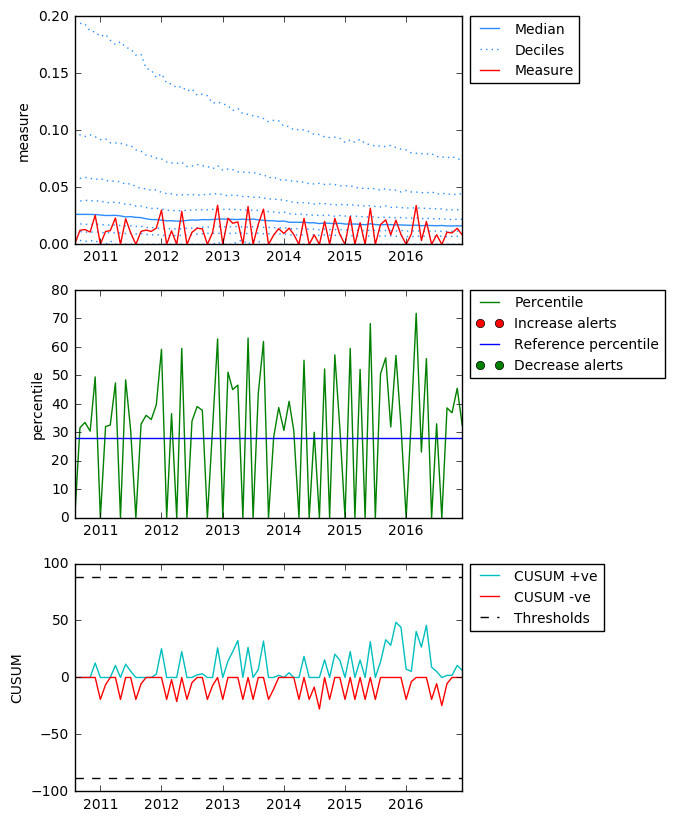




Measure: https://openprescribing.net/ccg/05Y/#icsdose


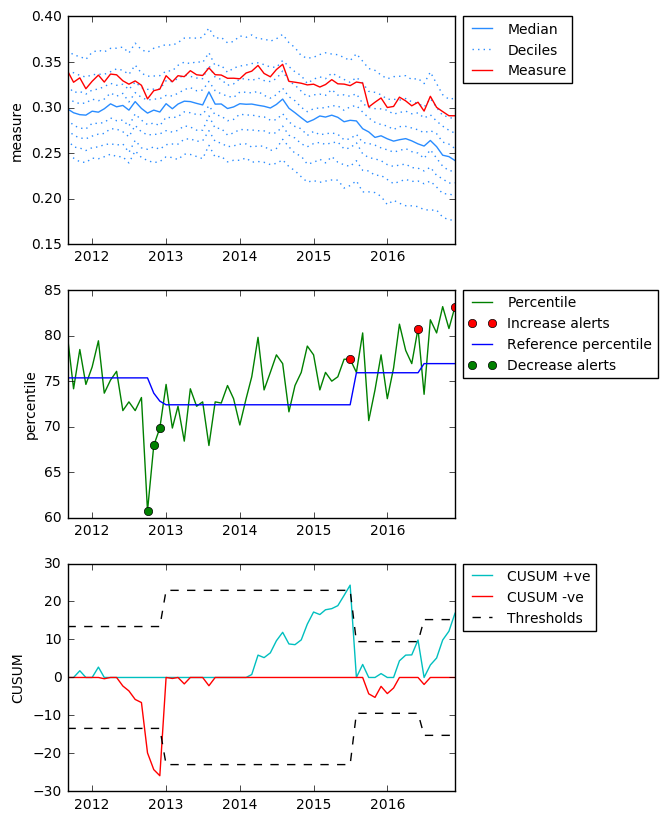




Measure: https://openprescribing.net/practice/G85138/#icsdose


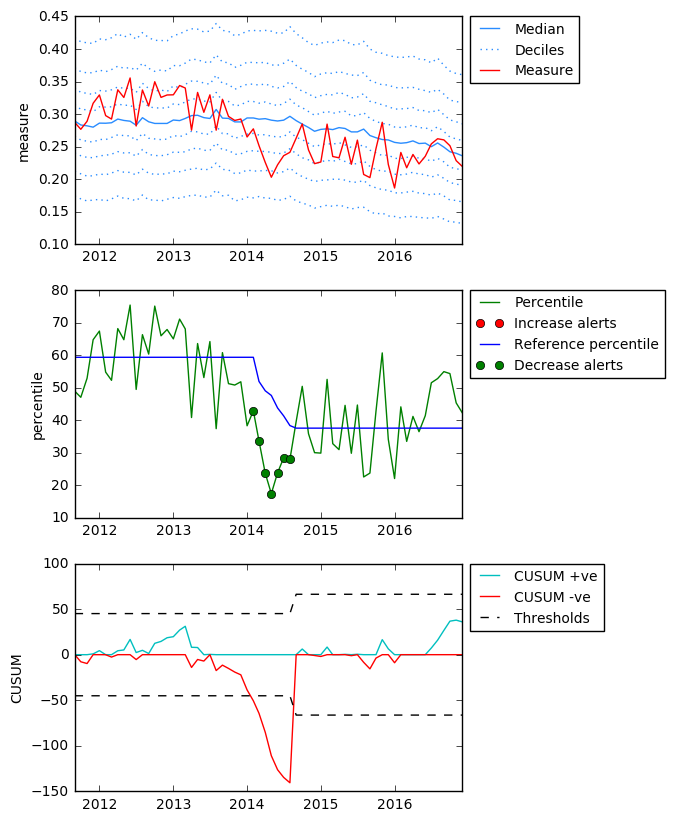




Measure: https://openprescribing.net/ccg/05Y/#dipyridamole


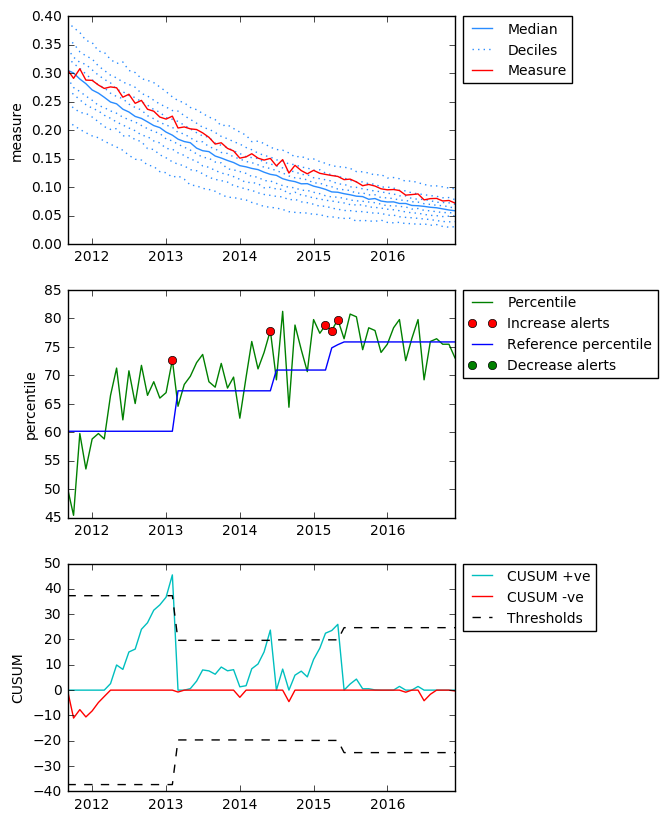




Measure: https://openprescribing.net/practice/G85138/#dipyridamole


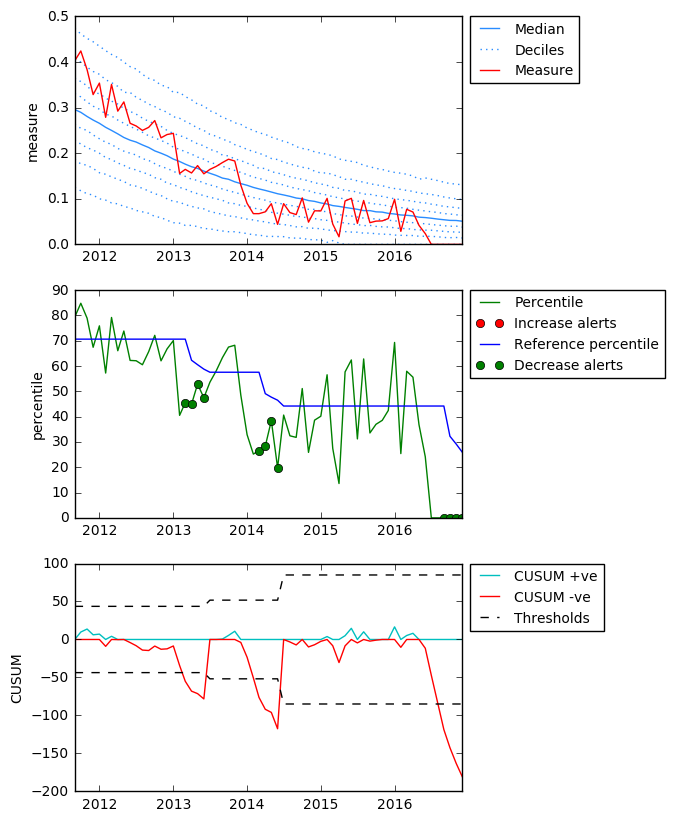




Measure: https://openprescribing.net/ccg/05Y/#methotrexate


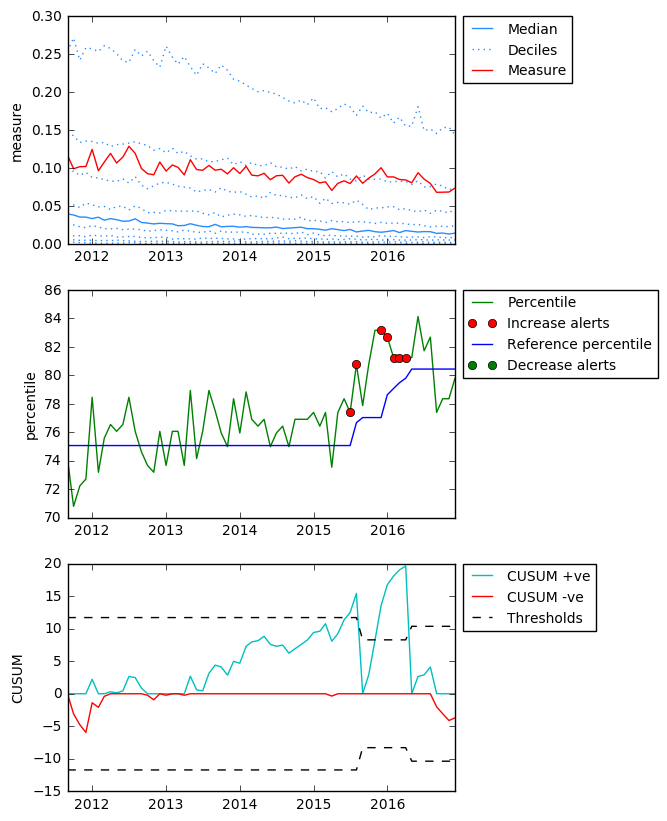




Measure: https://openprescribing.net/practice/G85138/#methotrexate


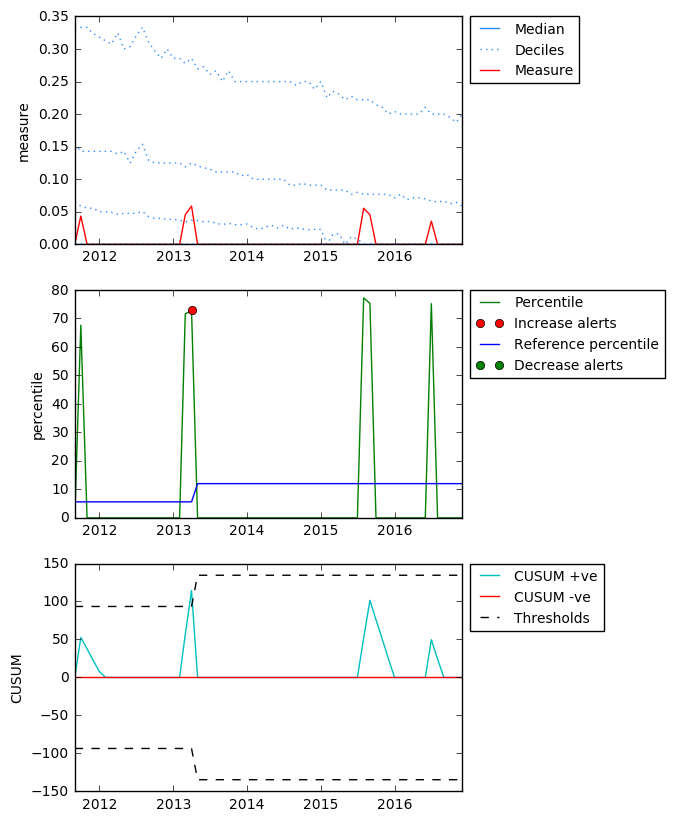




Measure: https://openprescribing.net/ccg/05Y/#vitb


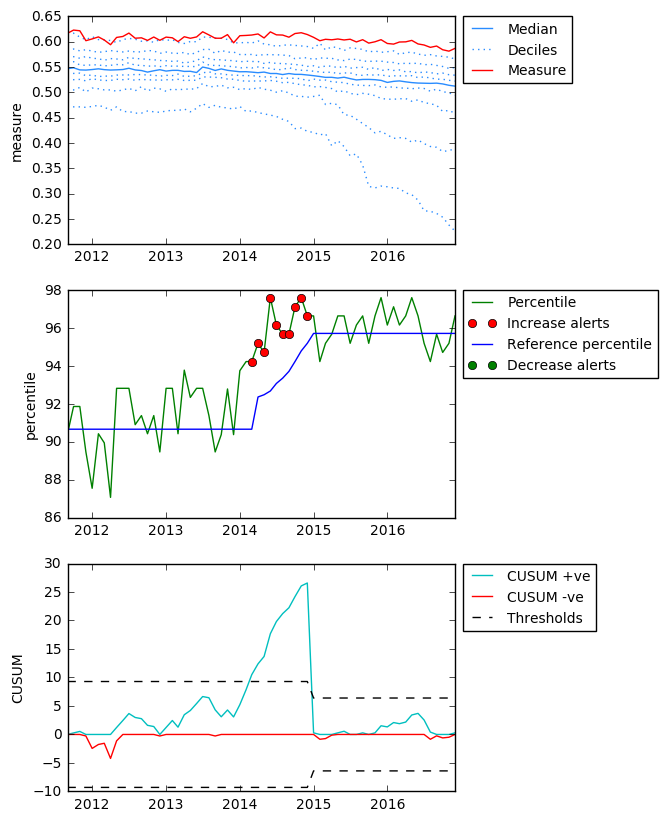




Measure: https://openprescribing.net/practice/G85138/#vitb


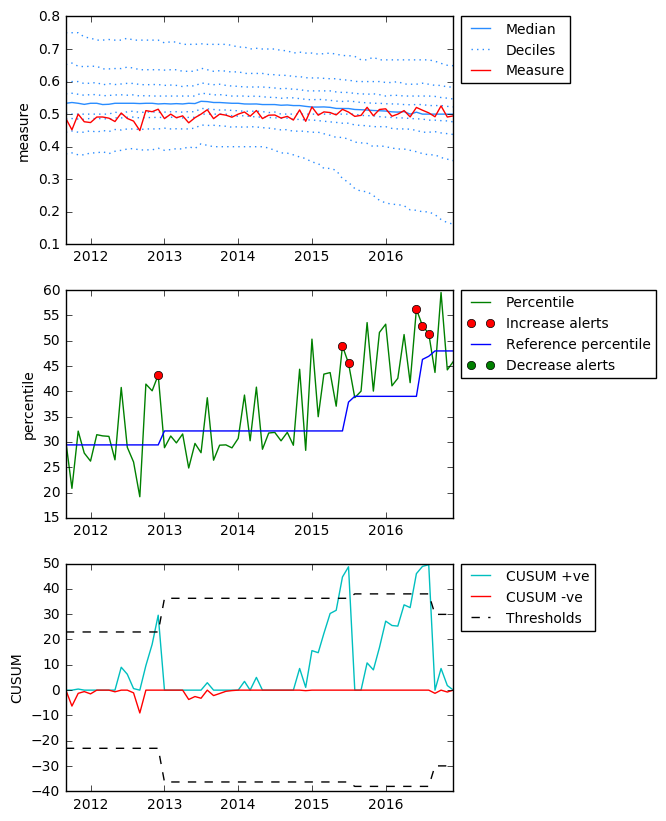




Measure: https://openprescribing.net/ccg/05Y/#solublepara


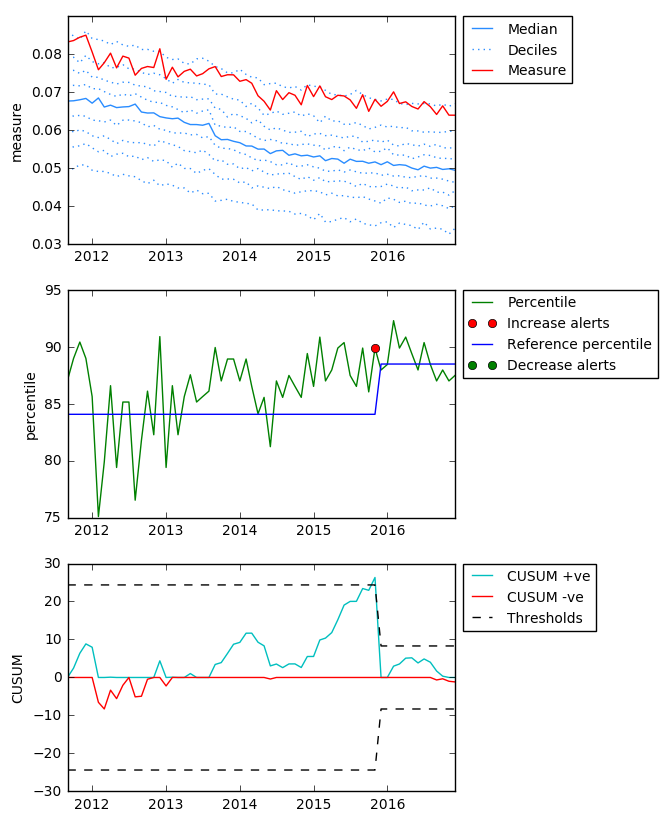




Measure: https://openprescribing.net/practice/G85138/#solublepara


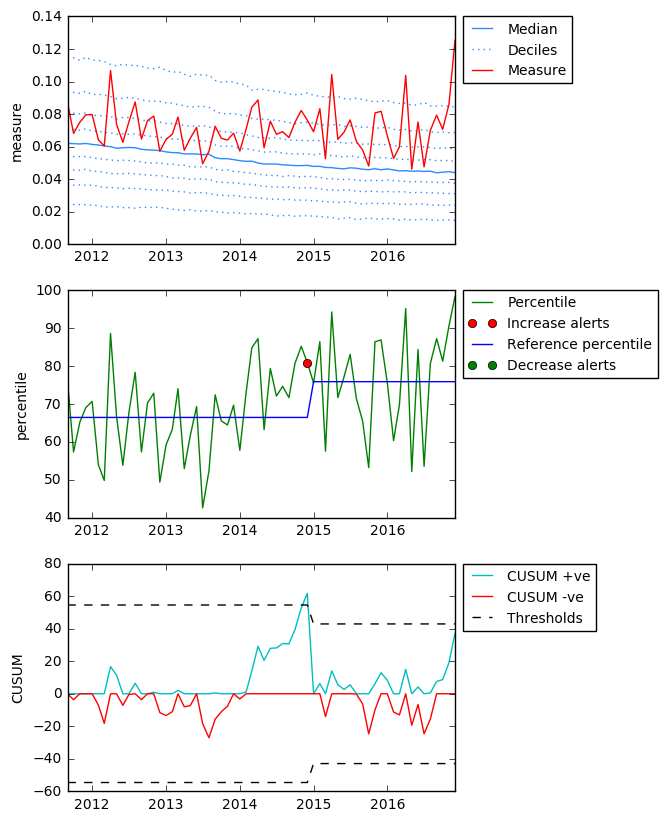




Measure: https://openprescribing.net/ccg/05Y/#ktt13_nsaids_ibuprofen


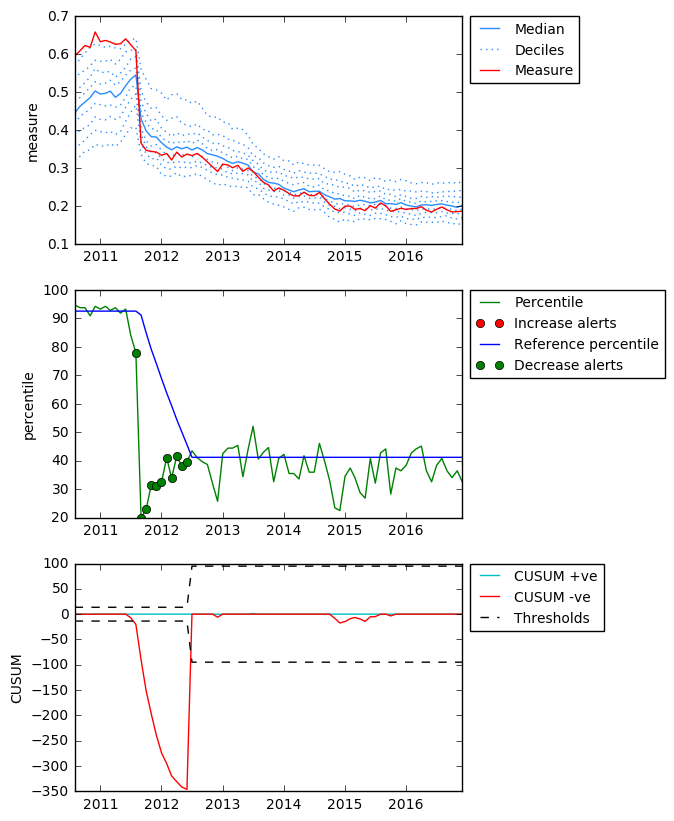




Measure: https://openprescribing.net/practice/G85138/#ktt13_nsaids_ibuprofen


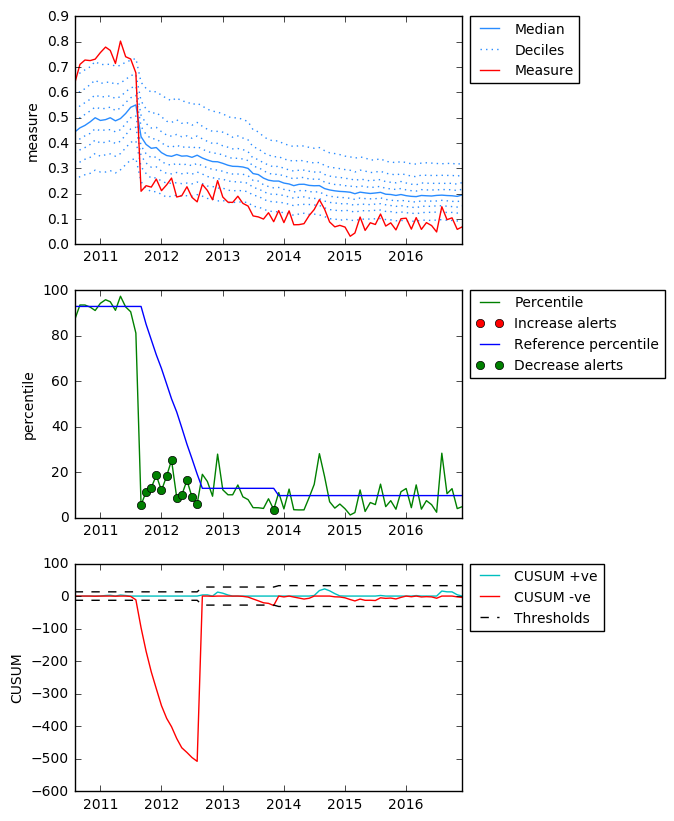




Measure: https://openprescribing.net/ccg/05Y/#ktt3_lipid_modifying_drugs


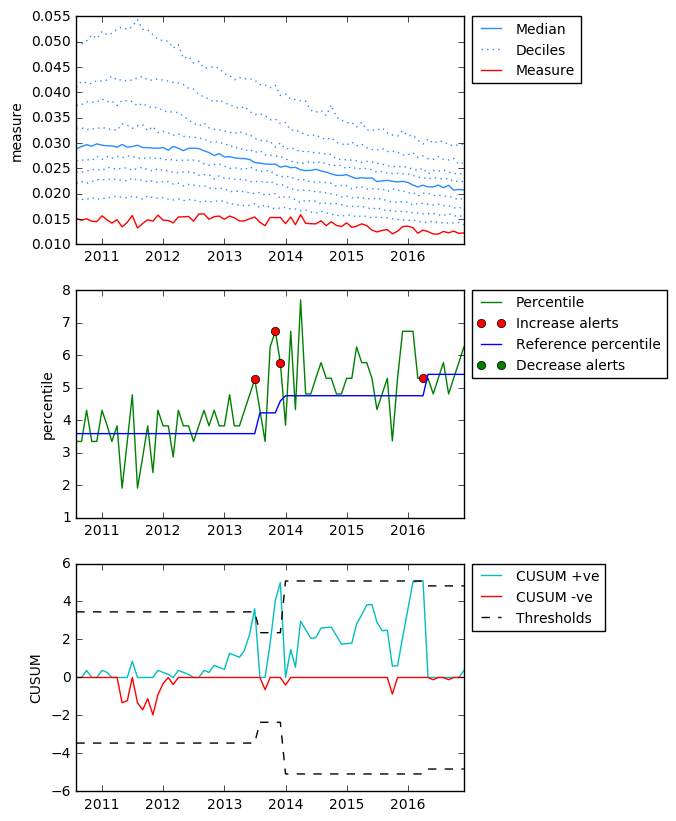




Measure: https://openprescribing.net/practice/G85138/#ktt3_lipid_modifying_drugs


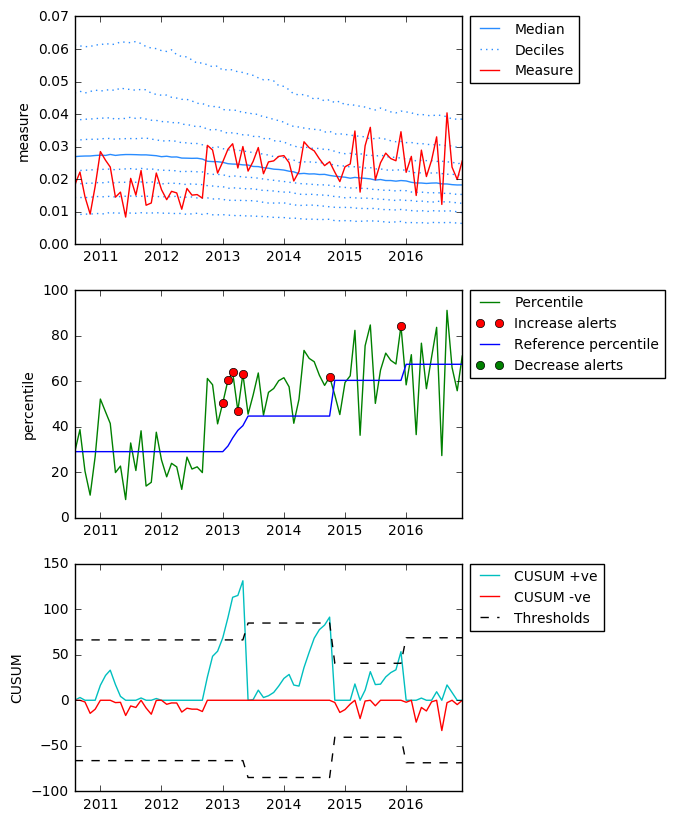




Measure: https://openprescribing.net/ccg/05Y/#doacs


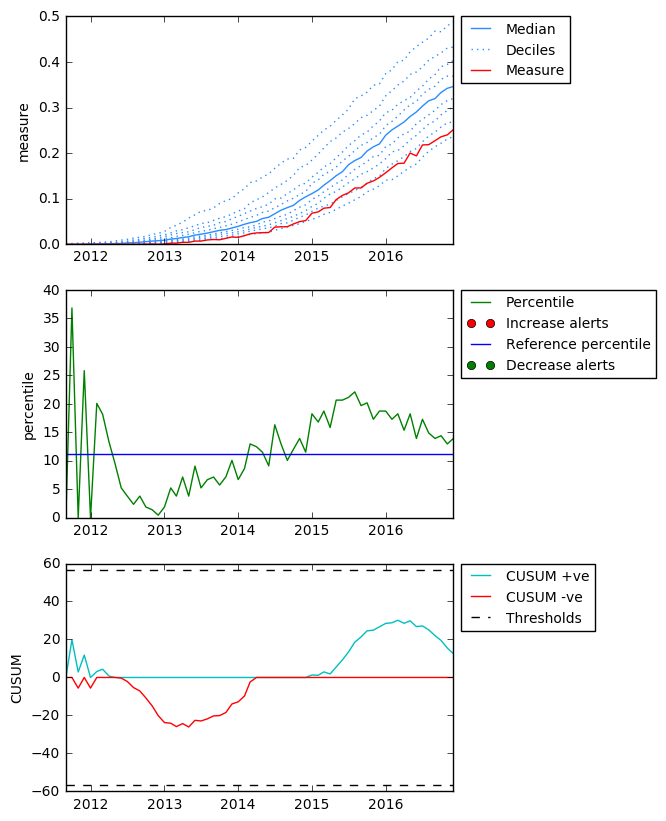




Measure: https://openprescribing.net/practice/G85138/#doacs


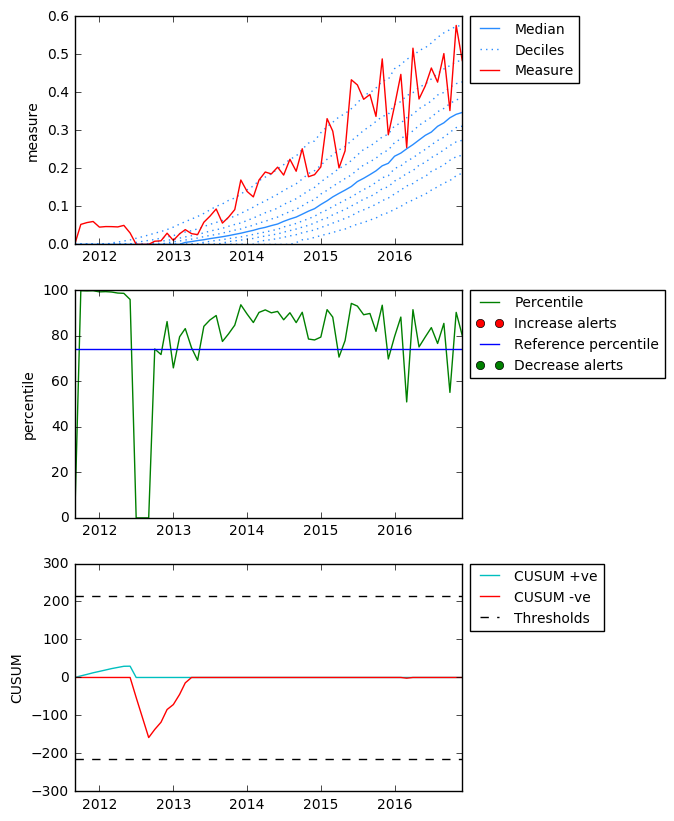




Measure: https://openprescribing.net/ccg/05Y/#opioidper1000


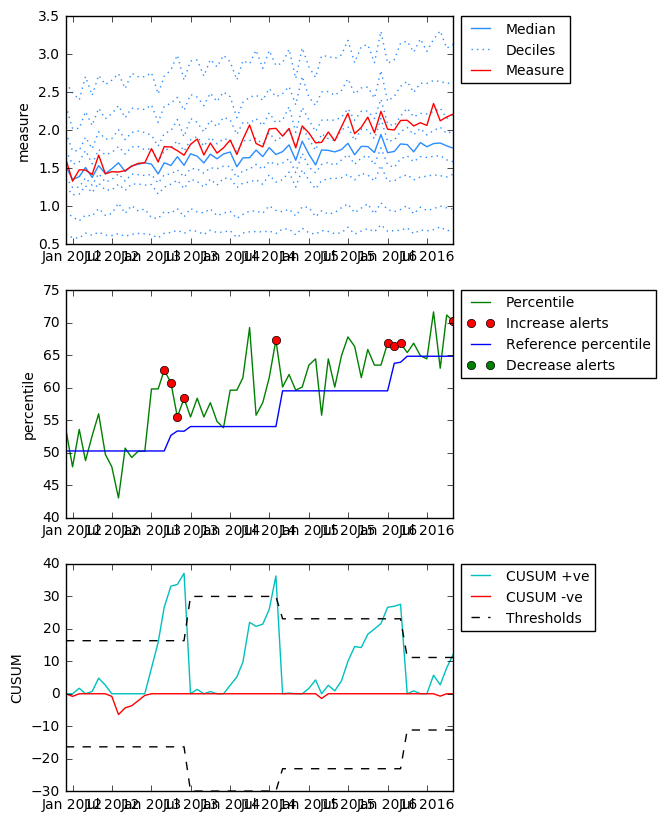




Measure: https://openprescribing.net/practice/G85138/#opioidper1000


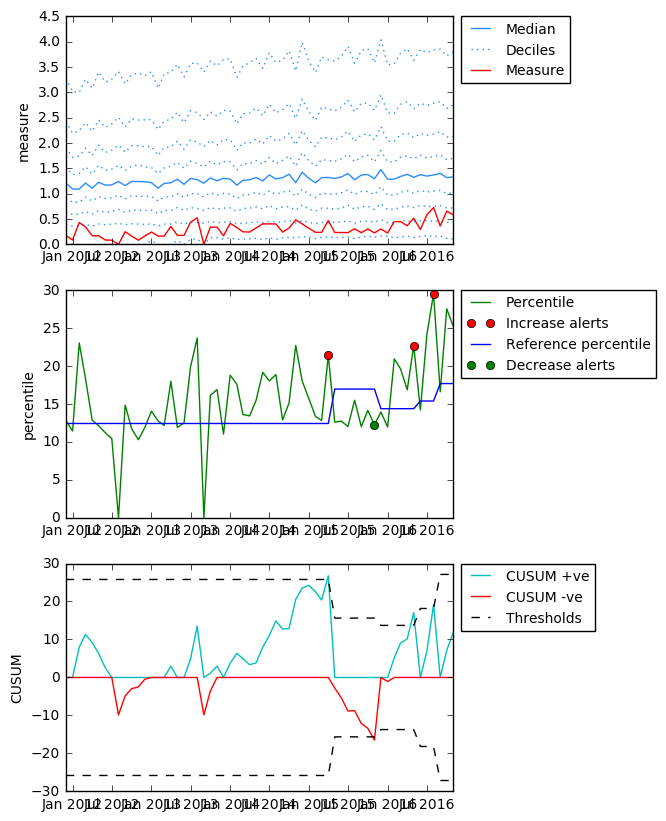




Measure: https://openprescribing.net/ccg/05Y/#ktt12_diabetes_insulin


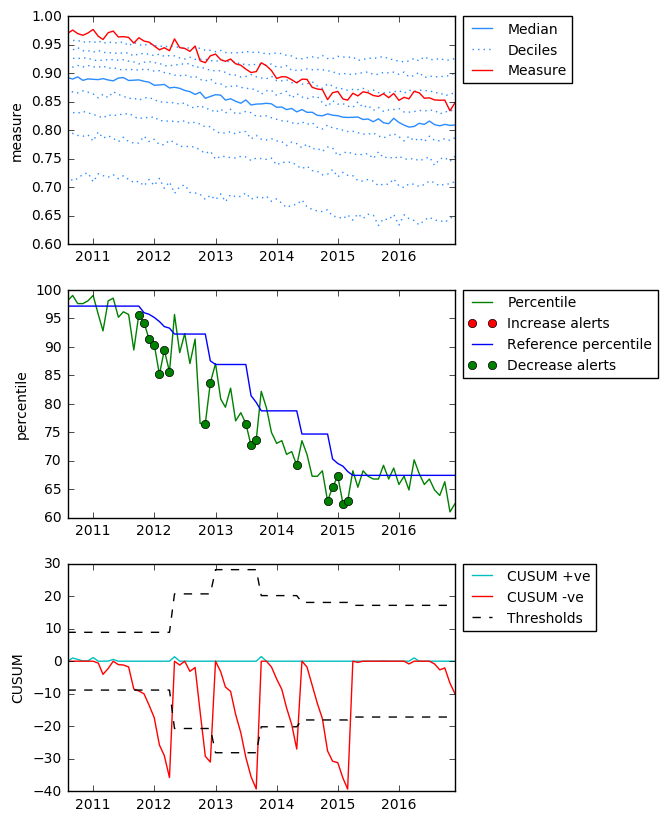




Measure: https://openprescribing.net/practice/G85138/#ktt12_diabetes_insulin


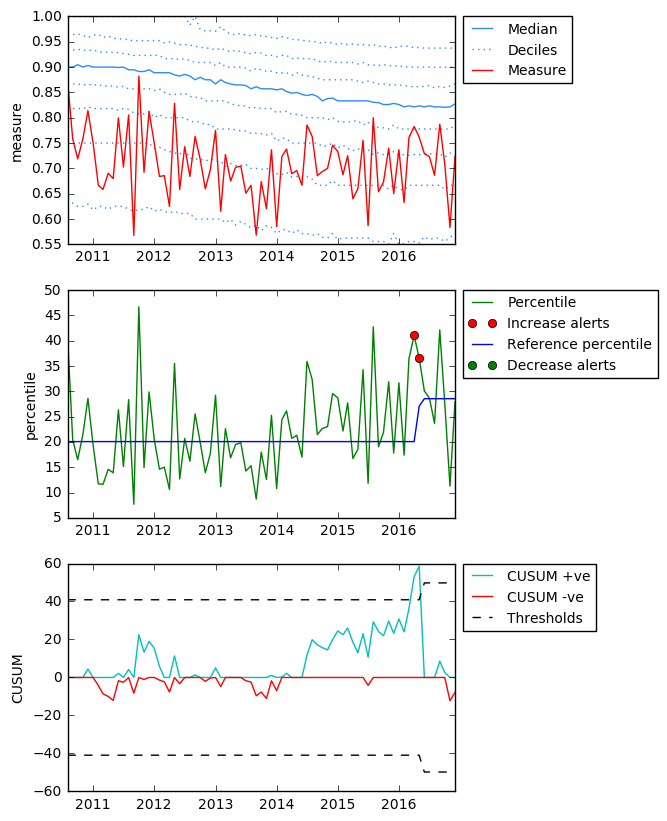




Measure: https://openprescribing.net/ccg/05Y/#ktt9_antibiotics


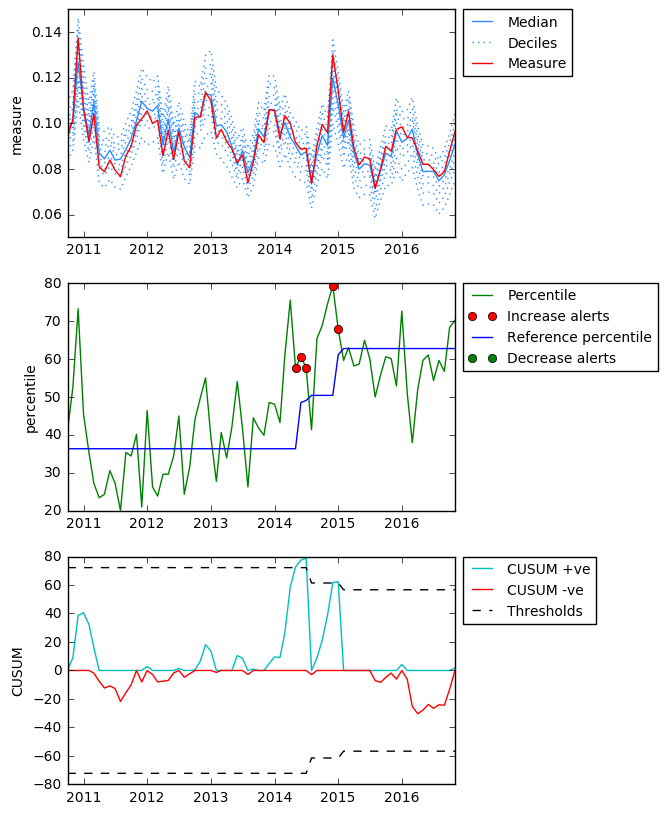




Measure: https://openprescribing.net/practice/G85138/#ktt9_antibiotics


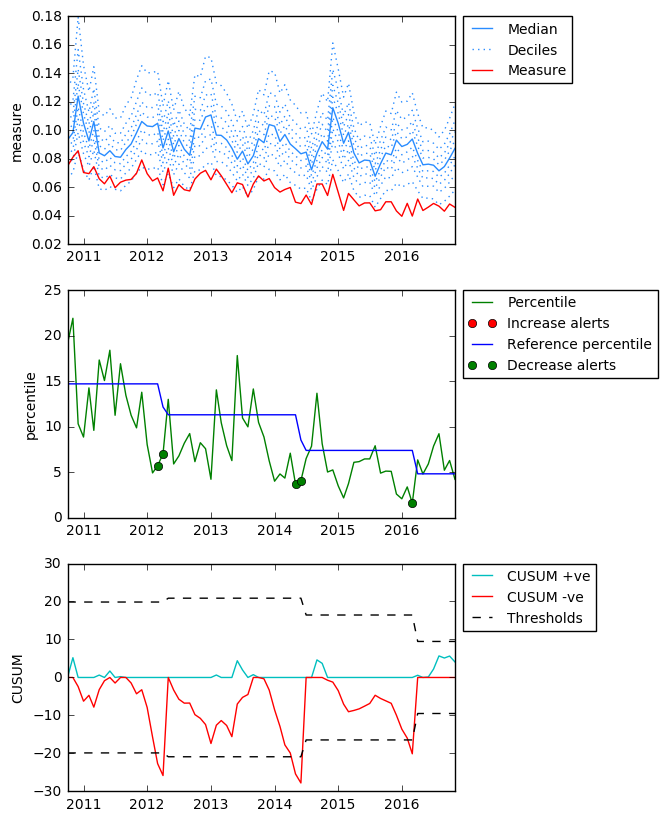




Measure: https://openprescribing.net/ccg/05Y/#pregabalin


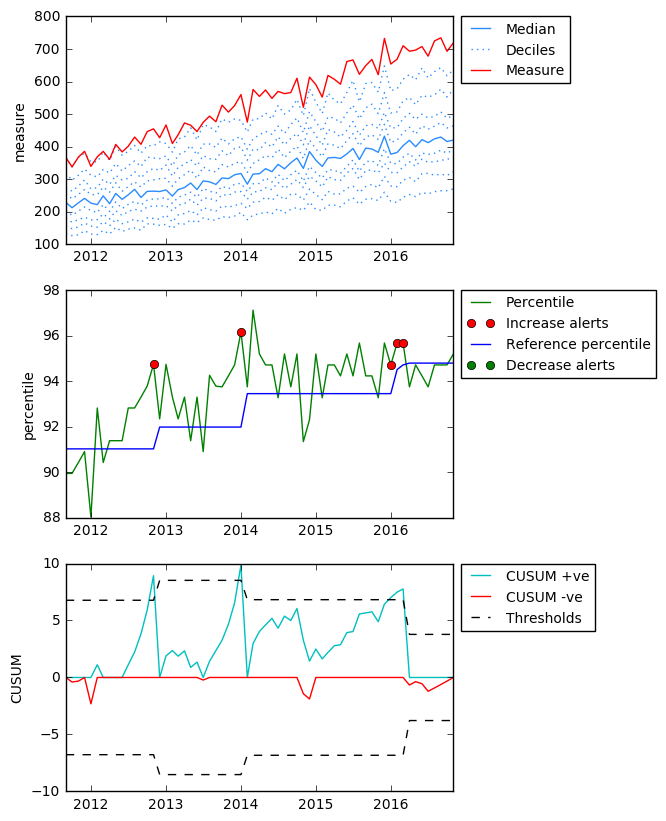




Measure: https://openprescribing.net/practice/G85138/#pregabalin


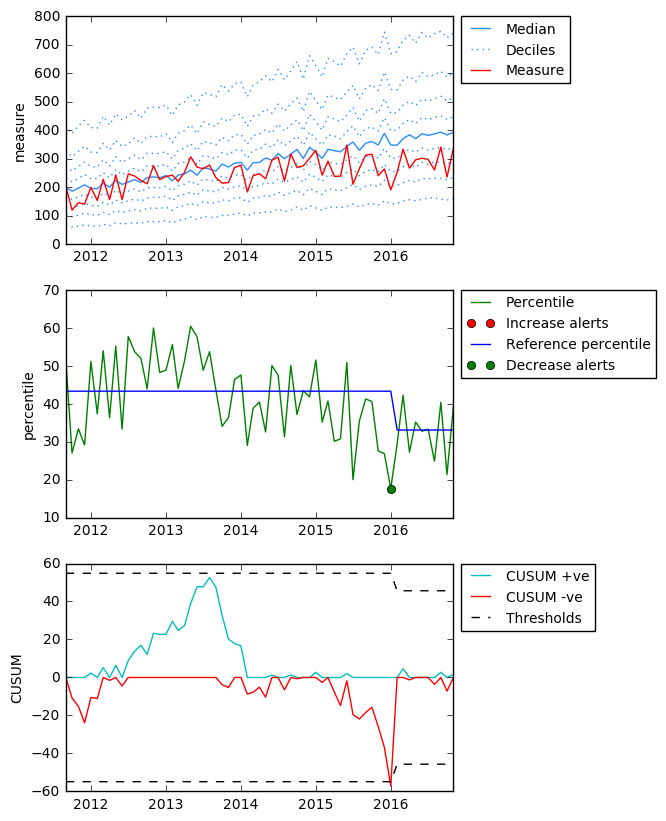




Measure: https://openprescribing.net/ccg/05Y/#diltiazem


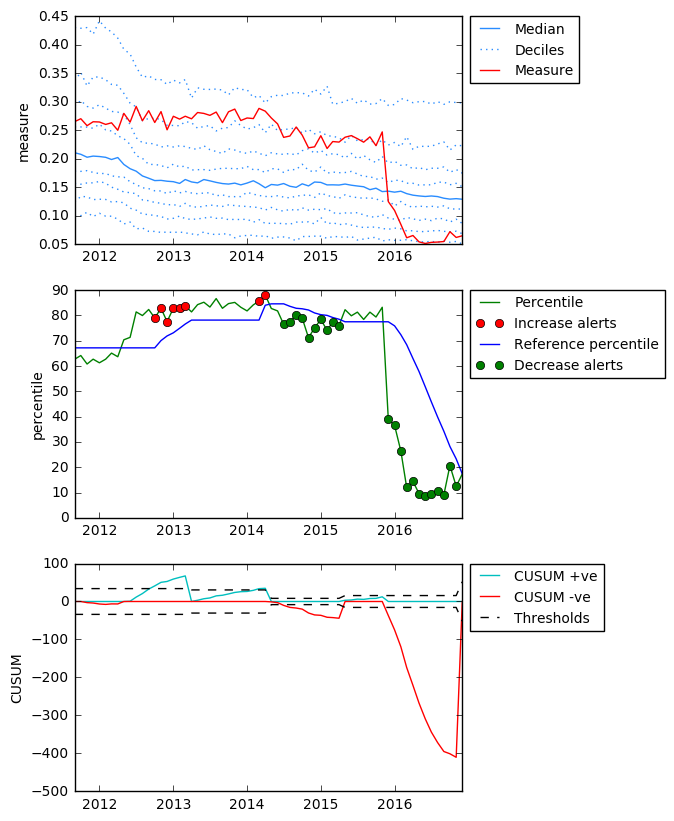




Measure: https://openprescribing.net/practice/G85138/#diltiazem


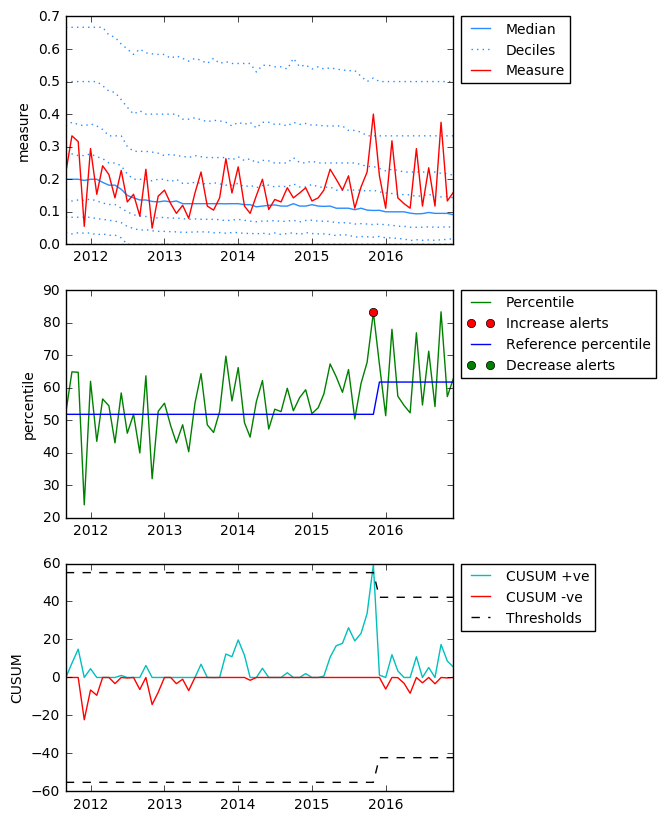




Measure: https://openprescribing.net/ccg/05Y/#coproxamol


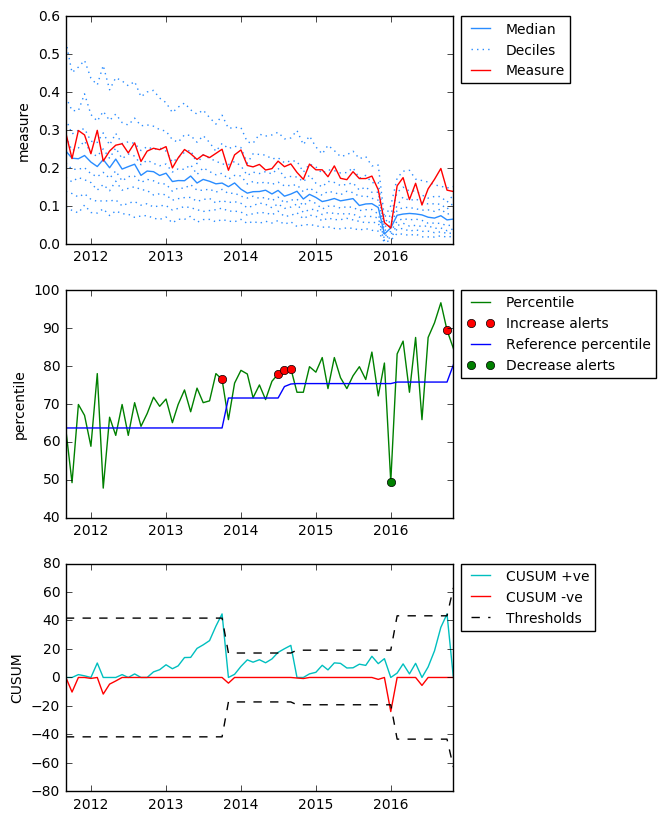




Measure: https://openprescribing.net/practice/G85138/#coproxamol


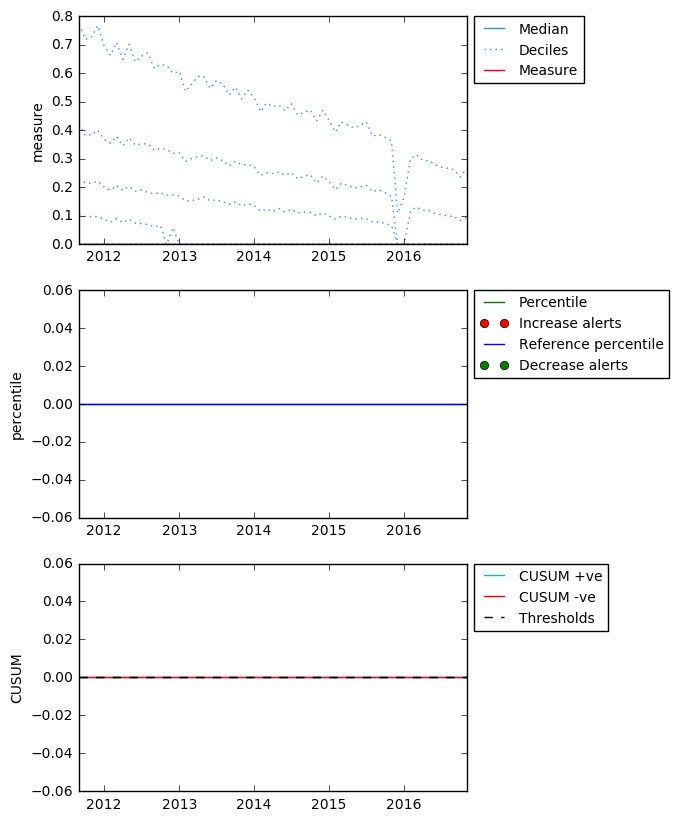




Measure: https://openprescribing.net/ccg/05Y/#opiates


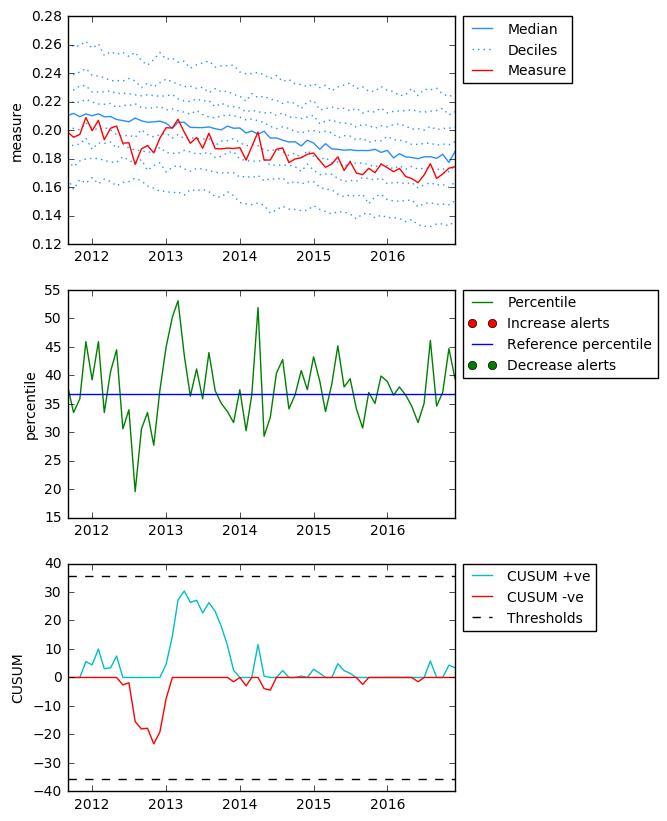




Measure: https://openprescribing.net/practice/G85138/#opiates


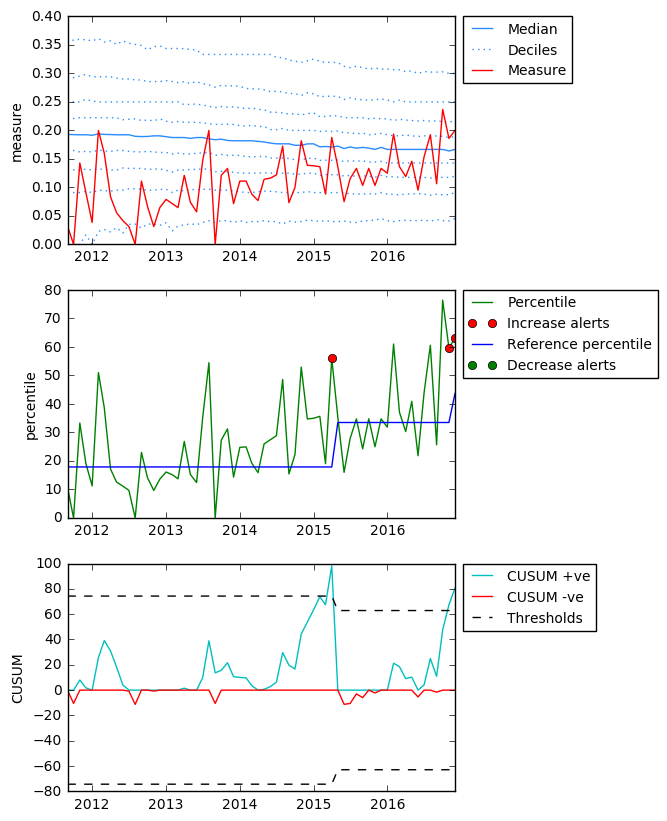




Measure: https://openprescribing.net/ccg/05Y/#ciclosporin


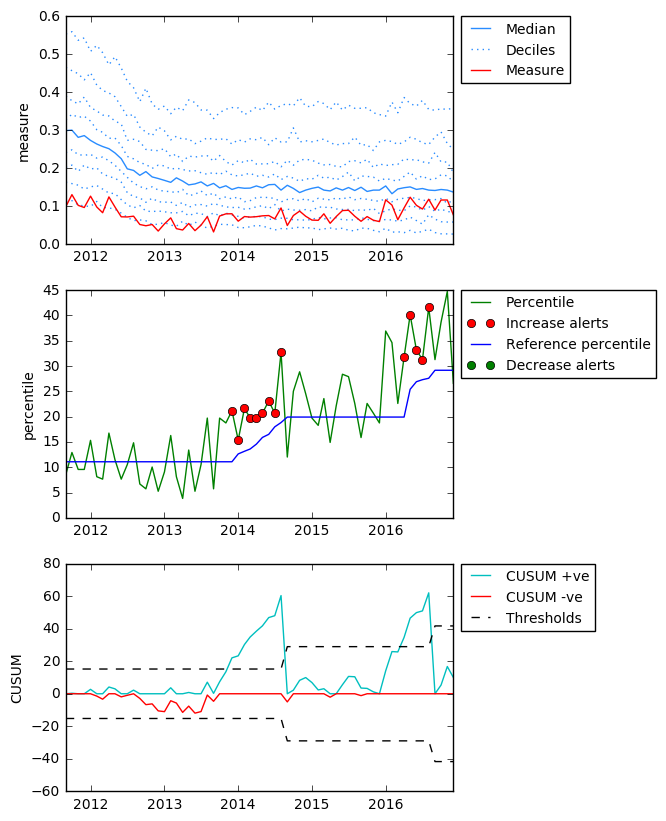




Measure: https://openprescribing.net/practice/G85138/#ciclosporin


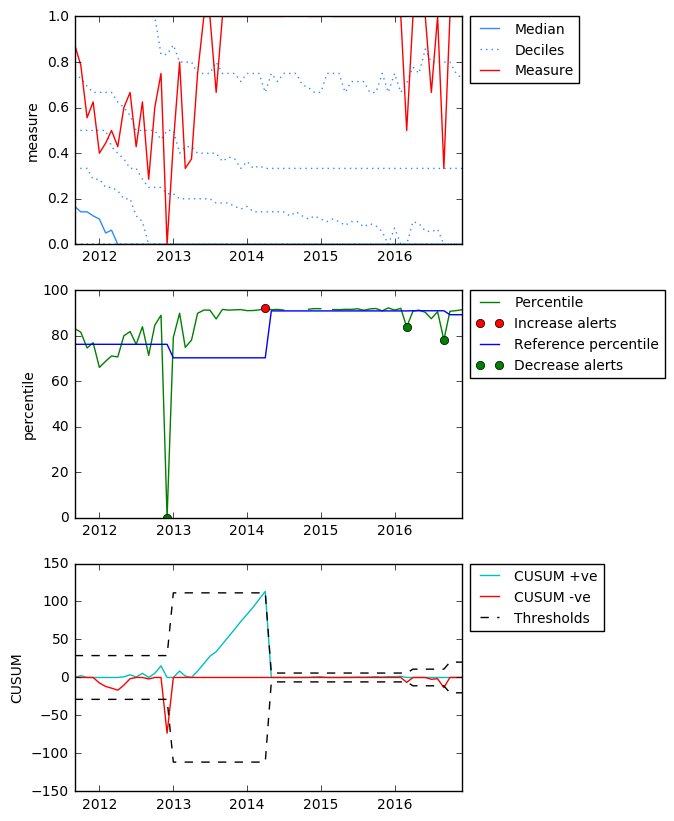




Measure: https://openprescribing.net/ccg/05Y/#cerazette


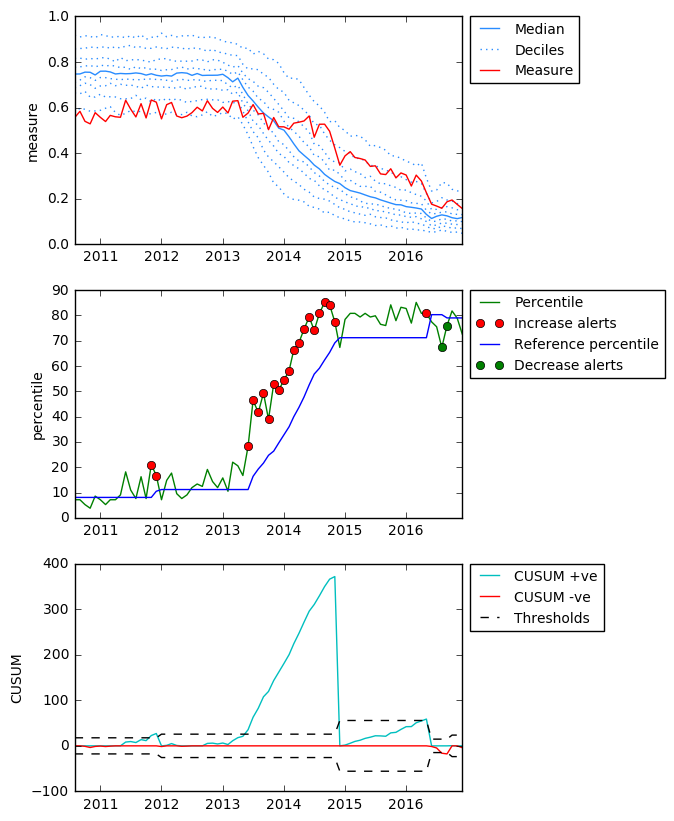




Measure: https://openprescribing.net/practice/G85138/#cerazette


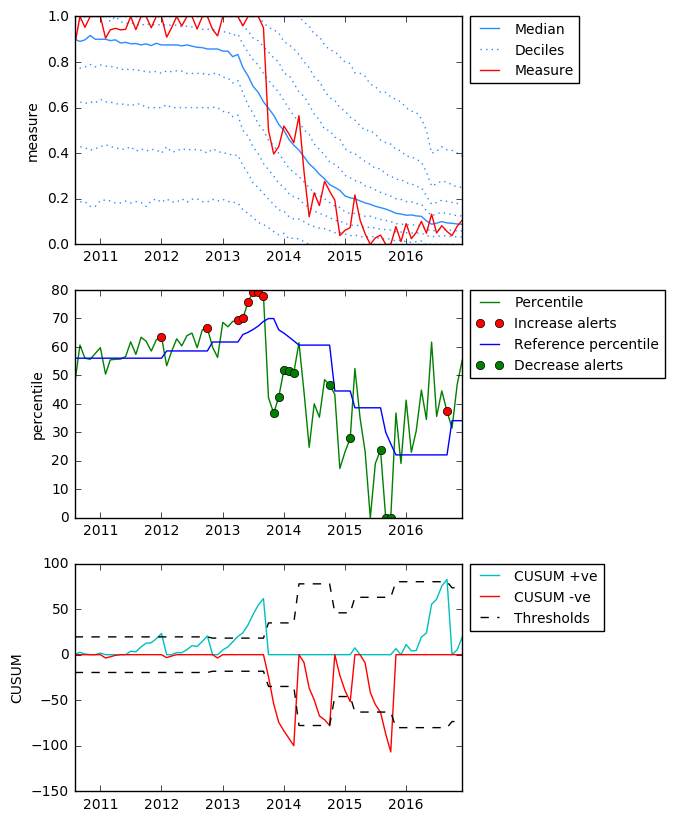




Measure: https://openprescribing.net/ccg/05Y/#nebivolol


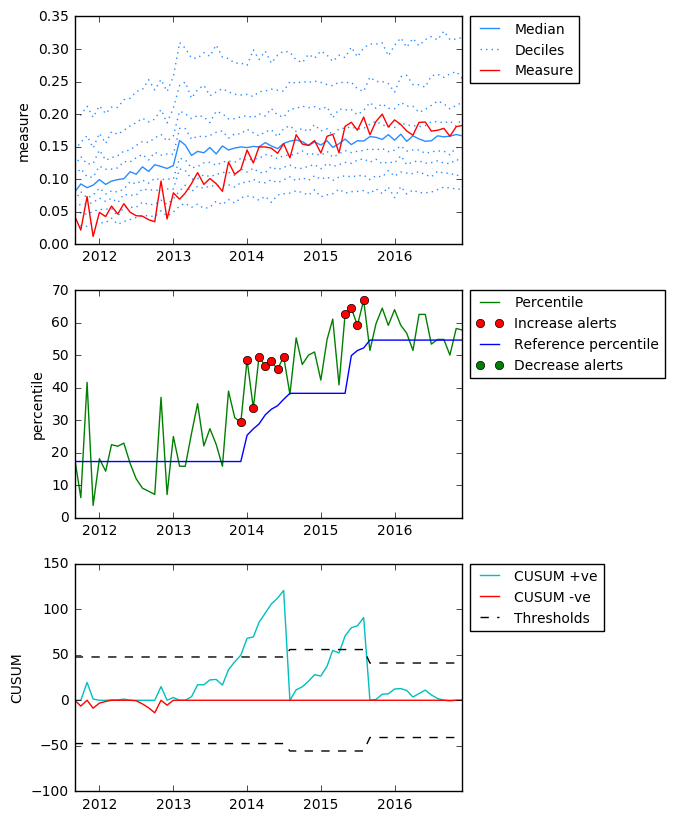




Measure: https://openprescribing.net/practice/G85138/#nebivolol


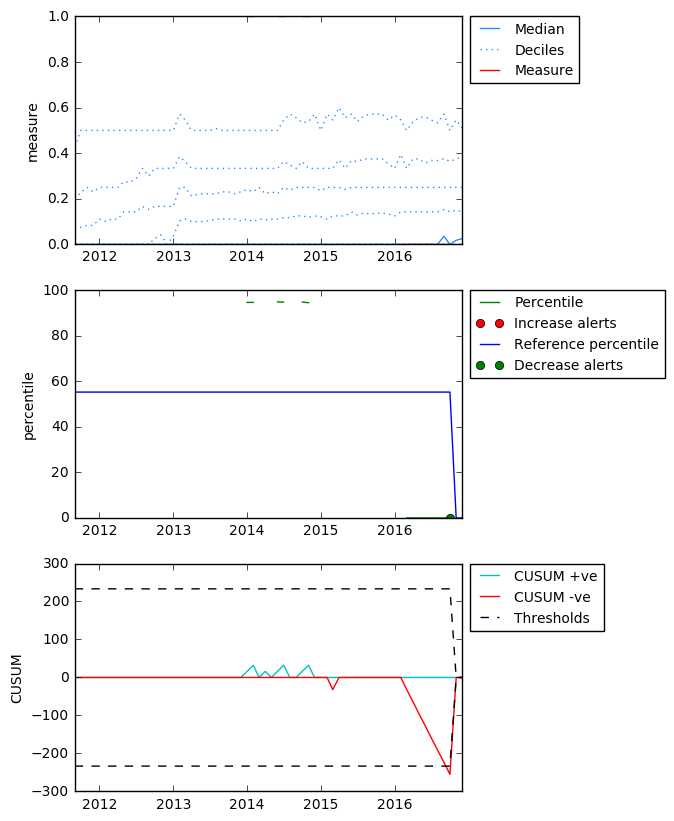




Measure: https://openprescribing.net/ccg/05Y/#ktt9_uti_antibiotics


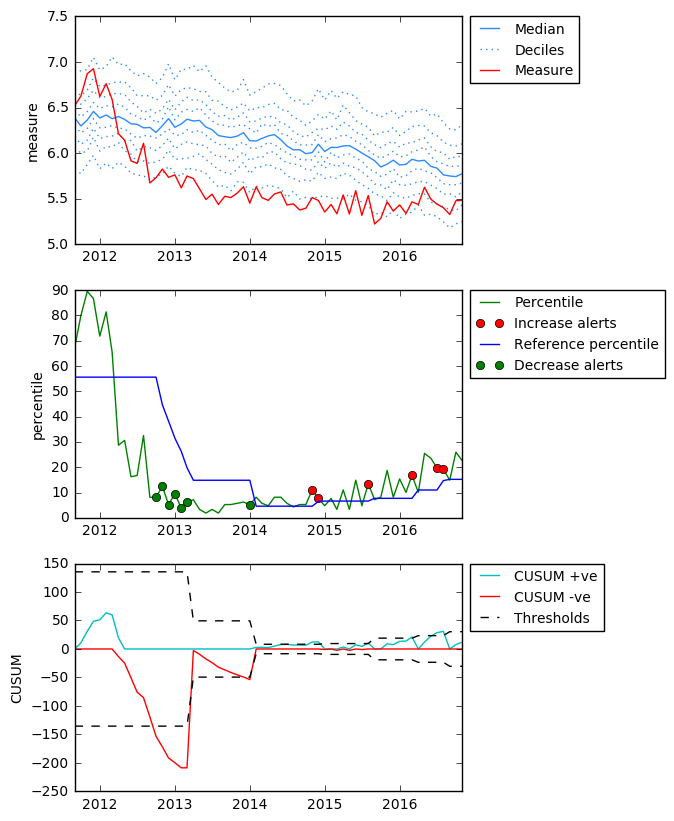




Measure: https://openprescribing.net/practice/G85138/#ktt9_uti_antibiotics


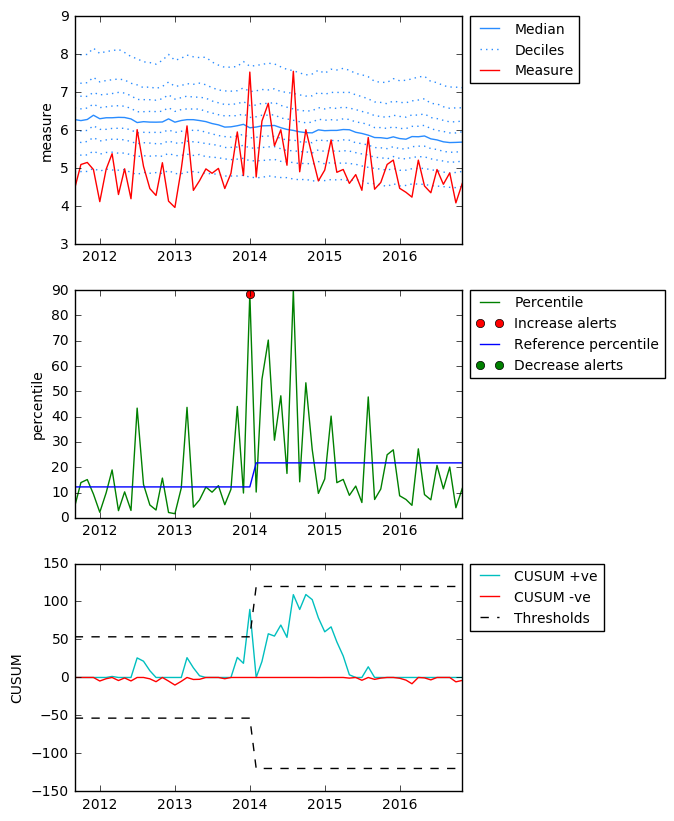




Measure: https://openprescribing.net/ccg/05Y/#ace


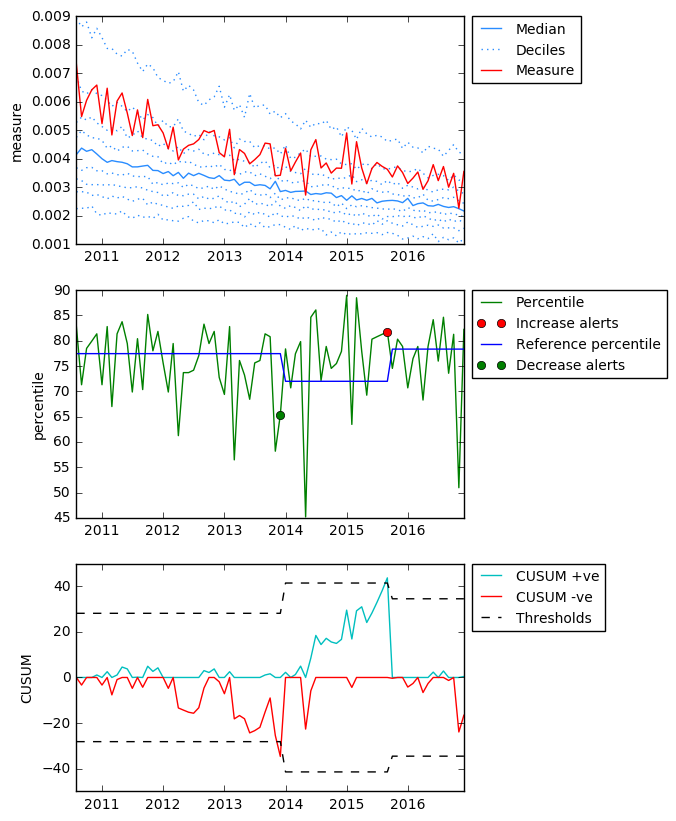




Measure: https://openprescribing.net/practice/G85138/#ace


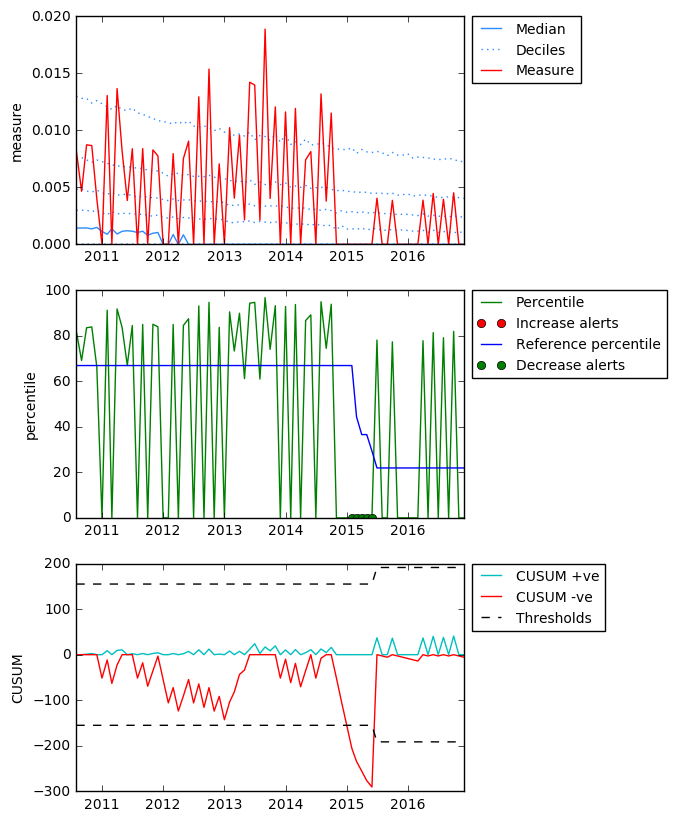




Measure: https://openprescribing.net/ccg/05Y/#statins


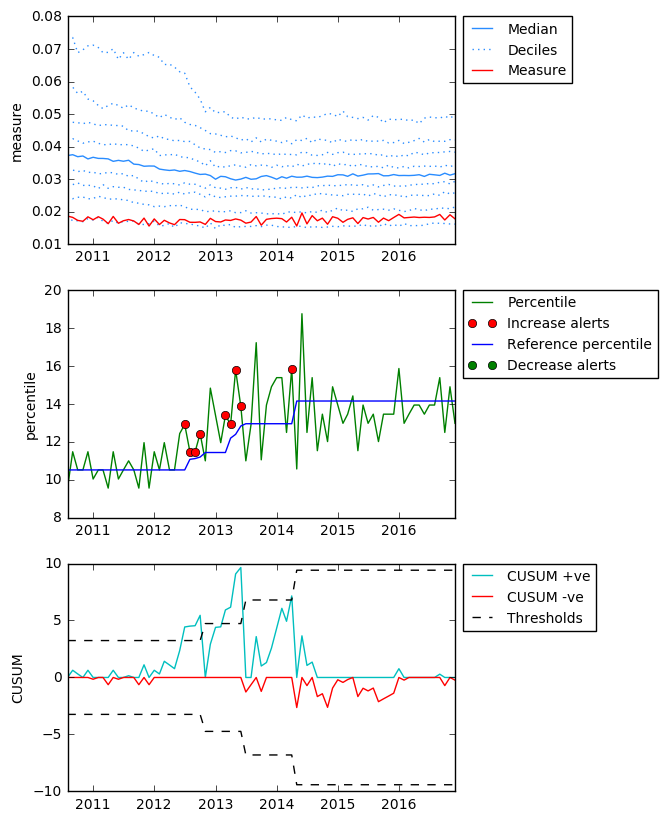




Measure: https://openprescribing.net/practice/G85138/#statins


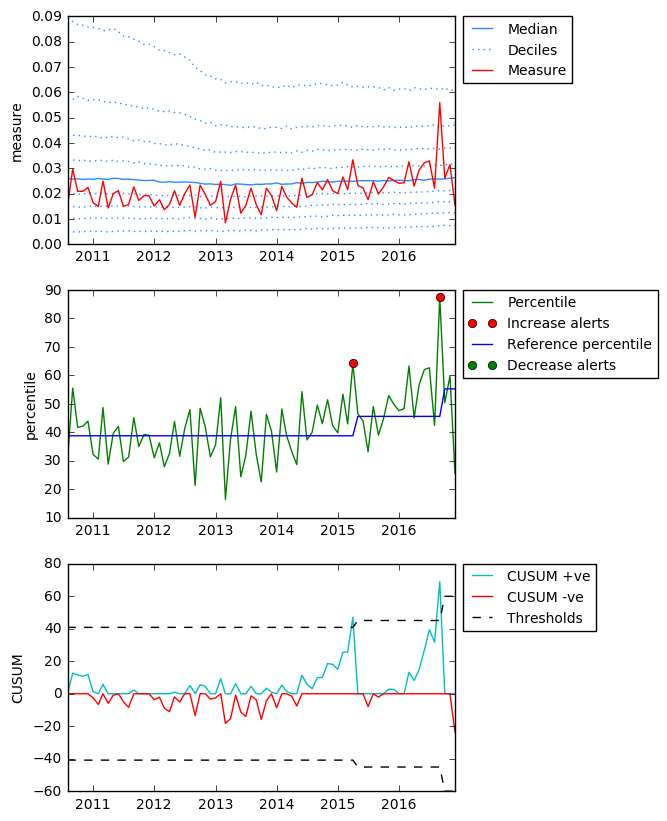




Measure: https://openprescribing.net/ccg/05Y/#glaucoma


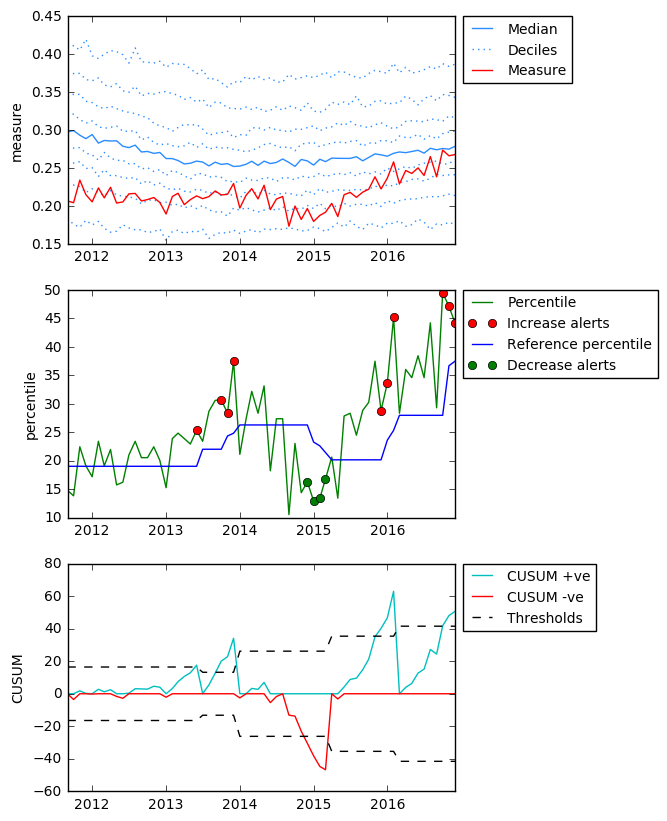




Measure: https://openprescribing.net/practice/G85138/#glaucoma


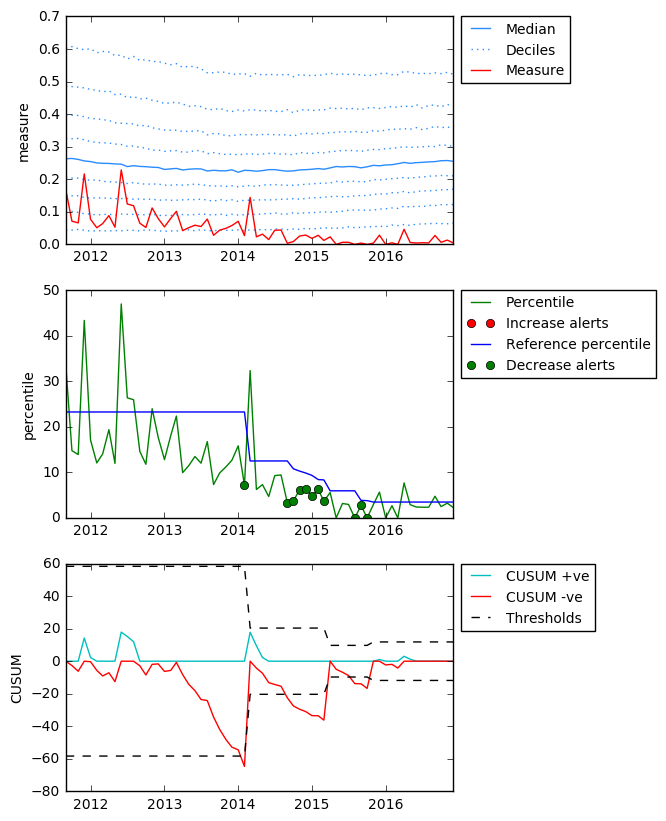




Measure: https://openprescribing.net/ccg/05Y/#ppidose


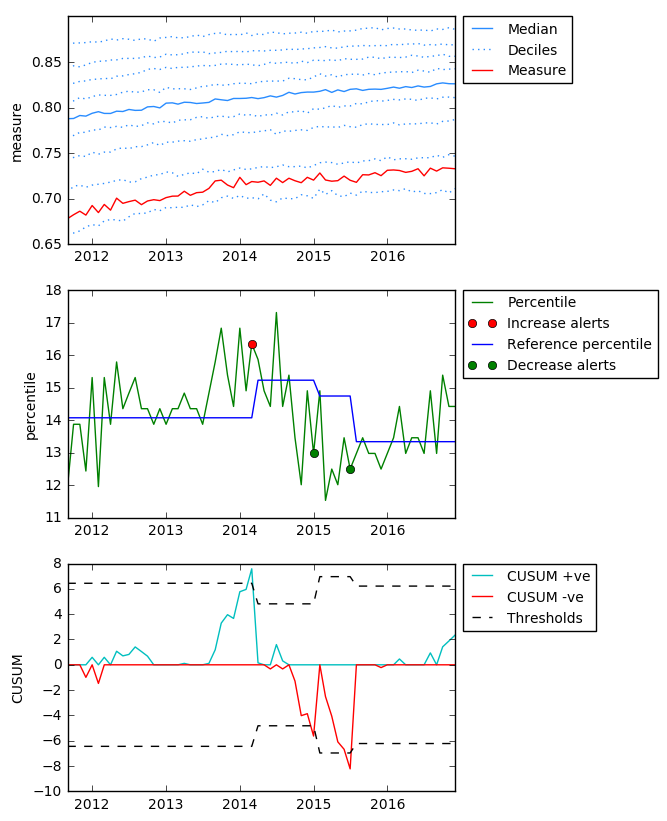




Measure: https://openprescribing.net/practice/G85138/#ppidose


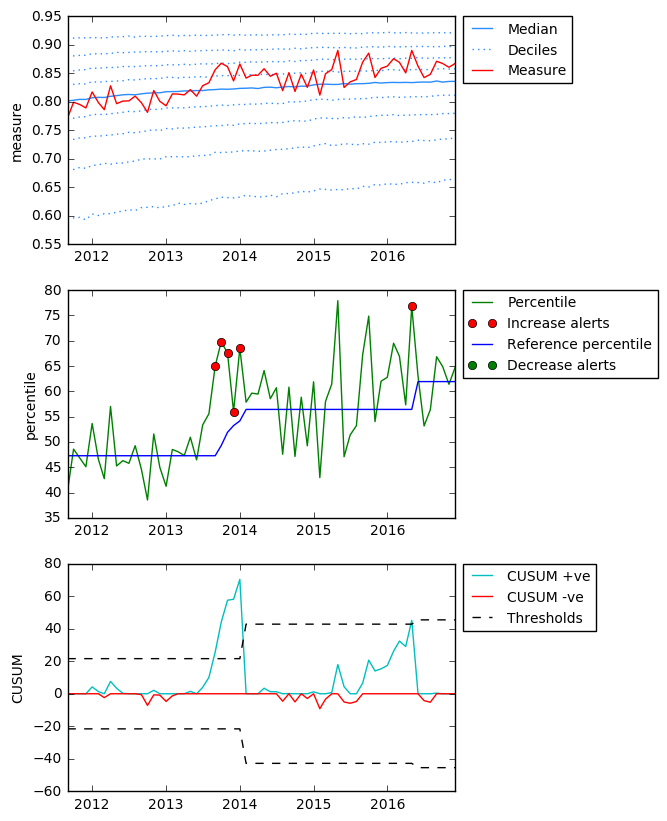




Measure: https://openprescribing.net/ccg/05Y/#ktt9_cephalosporins


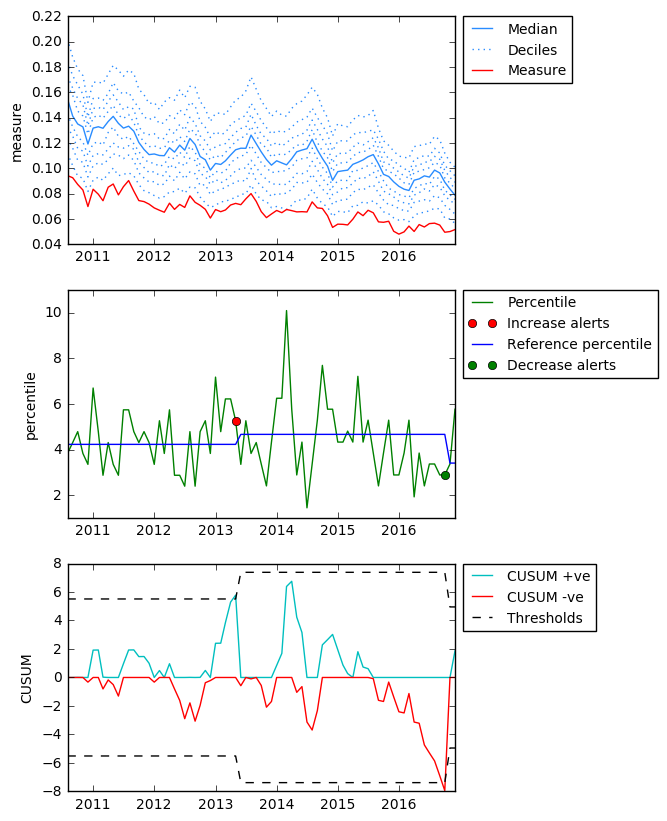




Measure: https://openprescribing.net/practice/G85138/#ktt9_cephalosporins


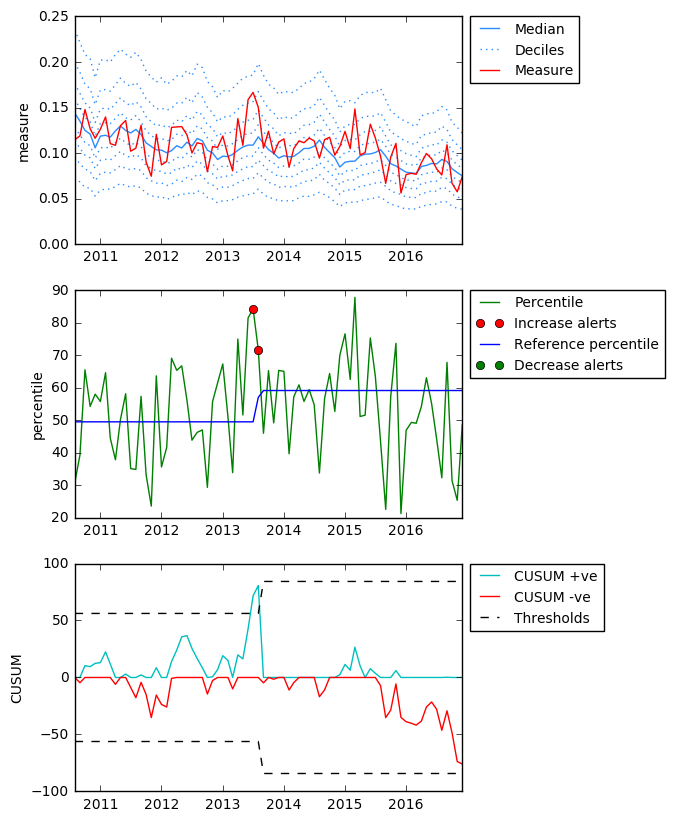




Measure: https://openprescribing.net/ccg/05Y/#quetiapine


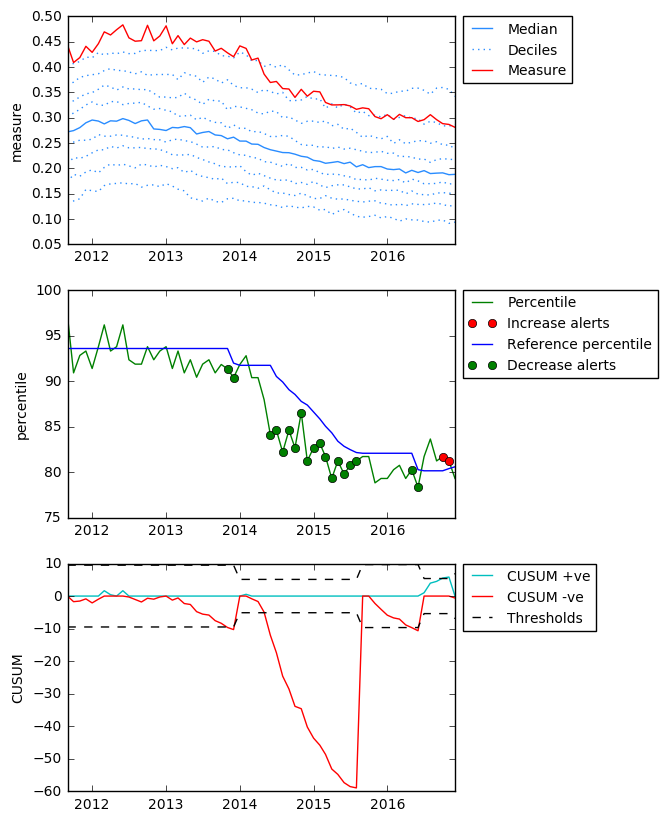




Measure: https://openprescribing.net/practice/G85138/#quetiapine


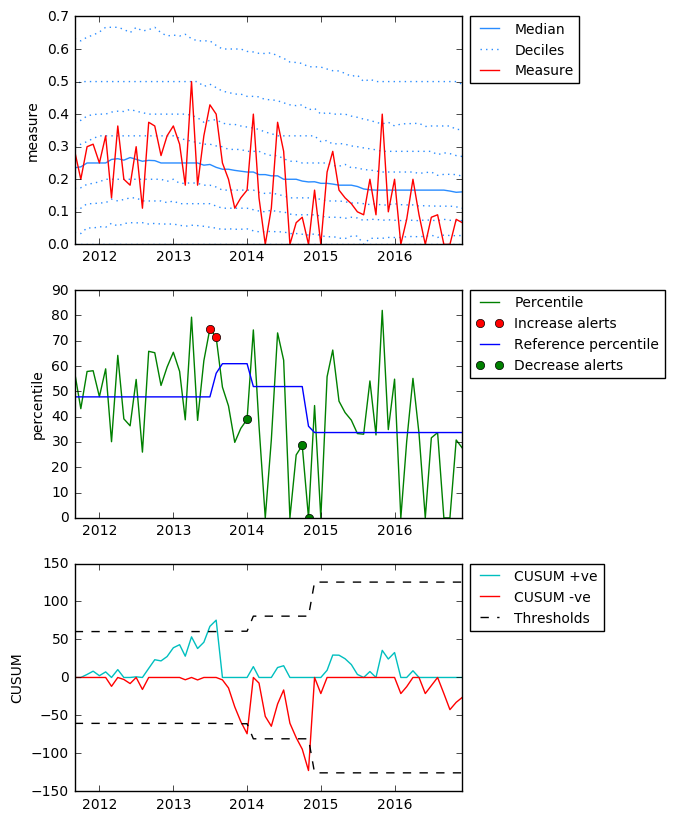




Measure: https://openprescribing.net/ccg/05Y/#saba


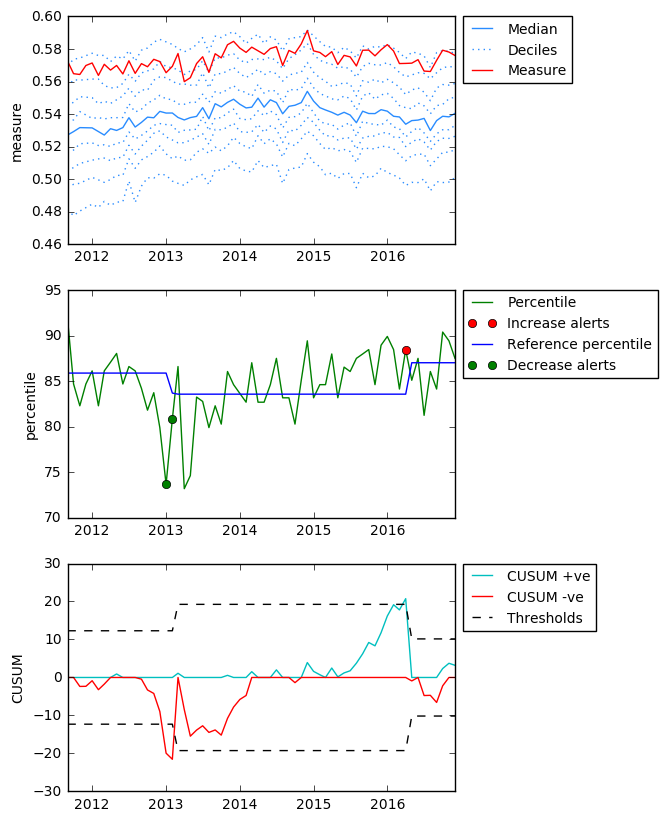




Measure: https://openprescribing.net/practice/G85138/#saba


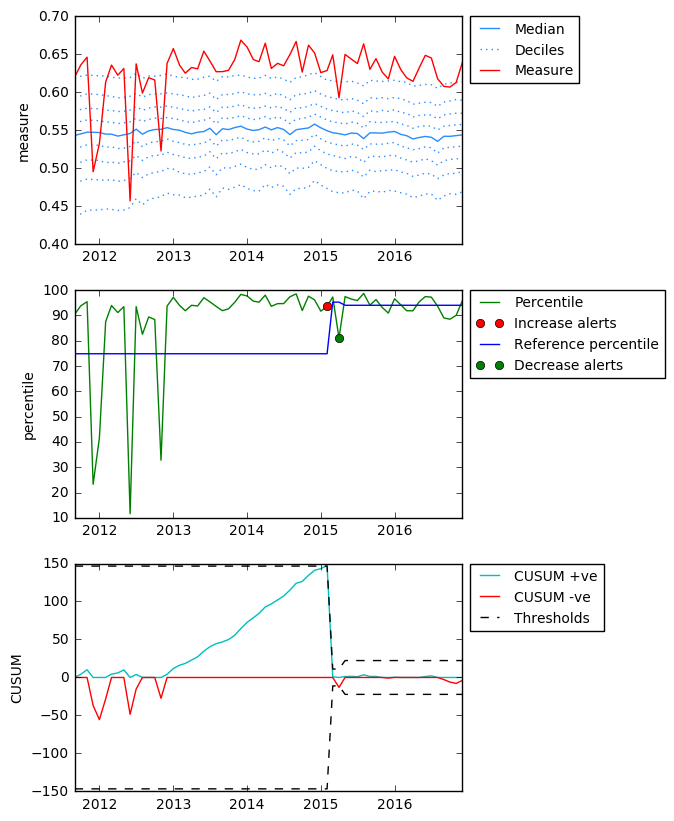




Measure: https://openprescribing.net/ccg/05Y/#keppra


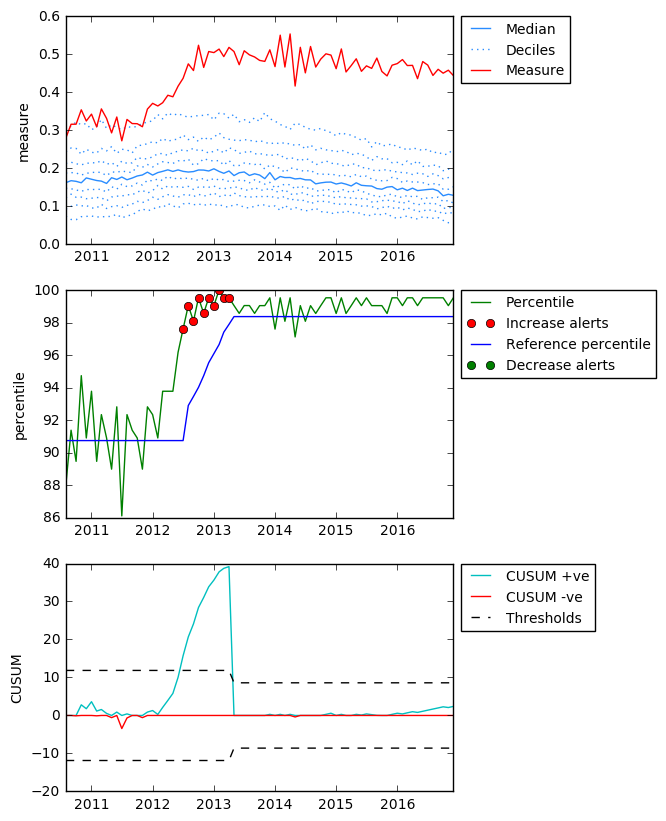




Measure: https://openprescribing.net/practice/G85138/#keppra


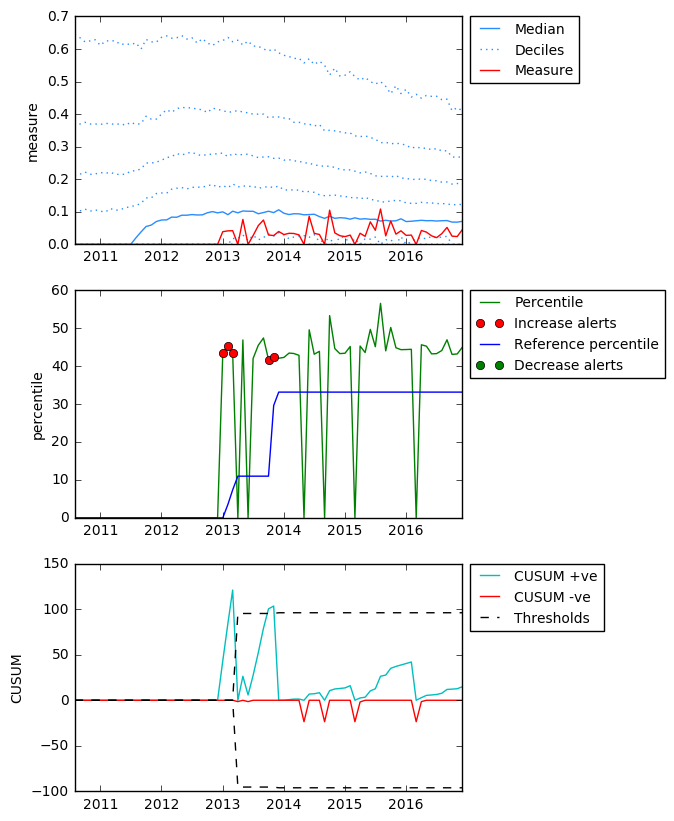




Measure: https://openprescribing.net/ccg/05Y/#silver


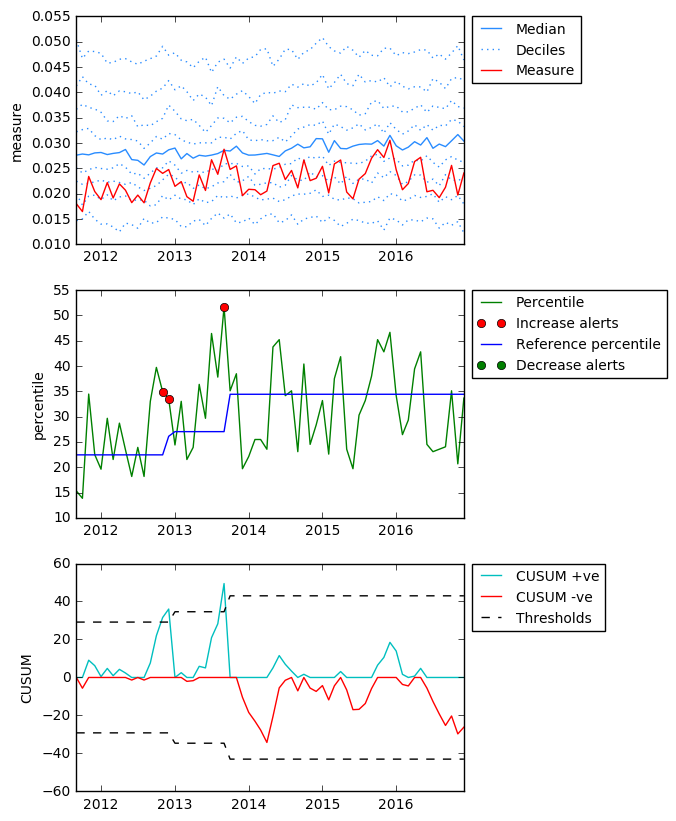




Measure: https://openprescribing.net/practice/G85138/#silver


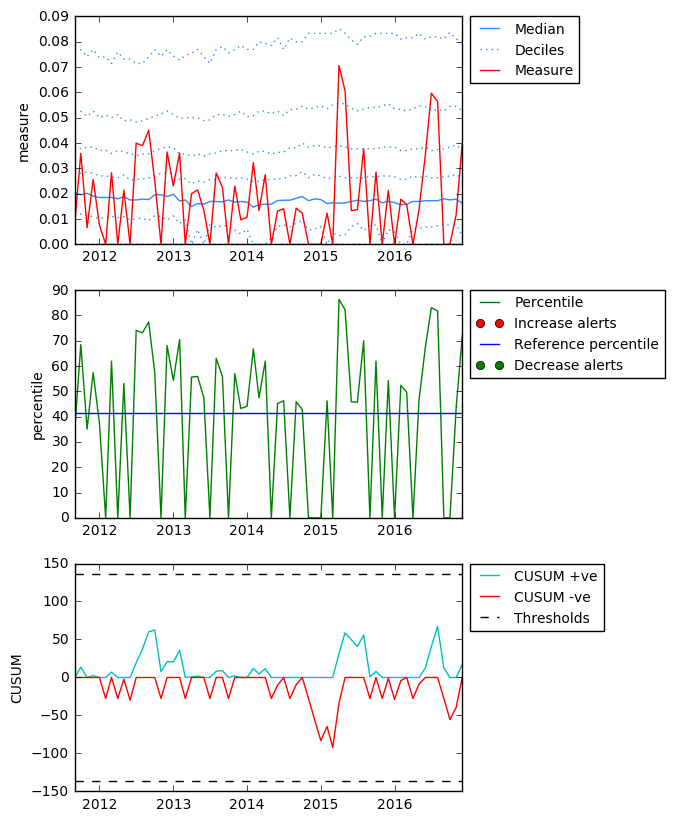

In [19]:
#RUN ANALYIS AND DRAW PLOTS -for all measures for 05Y and G85138
for measure in get_measures():
    for location in ['05Y','G85138']:
        analyse(measure, location)